In [1]:
import practicalSPARQL
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import bqplot as bq

In [2]:
root_q = 'queries'
root_d = 'results'

# read login data
login = pd.read_json('config_sparql.json')
ENDPOINT = login['endpoint'][0]
USERNAME = login['username'][0]
PASSWORD = login['password'][0]

# create sparql object
sparql = practicalSPARQL.practicalWrapper(ENDPOINT)
sparql.setCredentials(USERNAME, PASSWORD)

print("--- Querying ENDPOINT: {} ---".format(ENDPOINT))

--- Querying ENDPOINT: http://devmeta.sphaera.mpiwg-berlin.mpg.de/sparql ---


In [3]:
q = practicalSPARQL.stringify_SPARQL('books_query.sparql')    # select data from the ttl file as a dataframe
books = sparql.select_as_dataframe(q)

In [4]:
q = practicalSPARQL.stringify_SPARQL('elements_query_050824.sparql')    # select data from the ttl file as a dataframe
df = sparql.select_as_dataframe(q)

In [5]:
df['cks'] = df['cks'].astype(str)
df['cks'] = df['cks'].str.split(', ')
df_exploded = df.explode('cks')

# Remove brackets, single quotes, double quotes, and leading/trailing whitespace
df_exploded['cks'] = df_exploded['cks'].str.replace(r"[\[\]\"']", "", regex=True).str.strip()

df_exploded.reset_index(drop=True, inplace=True)

In [6]:
# Count unique values in the specified column
unique_count = df_exploded['images'].nunique()

print(f"Number of unique values in 'images': {unique_count}")

Number of unique values in 'images': 20540


In [7]:
# Define the target cks values
target_cks = ['CK_07 Spheres', 'CK_08 Spheres', 'CK_09 Spheres', 'CK_10 Spheres', 'CK_11 Spheres', 'CK_12 Spheres']

# Step 1: Filter the DataFrame for rows where 'cks' is in the target_cks list
filtered_df_target_cks = df_exploded[df_exploded['cks'].isin(target_cks)]

# Step 2: Get the unique 'images' values associated with the target cks
images_with_target_cks = filtered_df_target_cks['images'].unique()

# Step 3: Filter the original DataFrame to include all rows that have these images
filtered_df = df_exploded[df_exploded['images'].isin(images_with_target_cks)]

# Display the filtered DataFrame
#filtered_df

In [8]:
# Count unique values in the specified column
unique_count = filtered_df['images'].nunique()

print(f"Number of unique values in 'images': {unique_count}")

Number of unique values in 'images': 392


In [9]:
# Count unique images associated with each cks value
unique_images_per_cks = filtered_df.groupby('cks')['images'].nunique()

# Print the results
print('Number of unique images associated with each cks value:')
print(unique_images_per_cks)

Number of unique images associated with each cks value:
cks
CK_07 Spheres                                           3
CK_08 Spheres                                          20
CK_09 Spheres                                          83
CK_10 Spheres                                         227
CK_11 Spheres                                          37
CK_12 Spheres                                          22
CK_Heliocentric Astronomy                               1
CK_Multiple Celestial Circles                           1
CK_Parallels                                            1
CK_Populated Earth                                     15
CK_Relation Between the Spheres of Water and Earth      1
CK_Right and Oblique Sphere                             2
CK_T-O Maps                                            54
CK_Terraqueous Globe                                  275
Name: images, dtype: int64


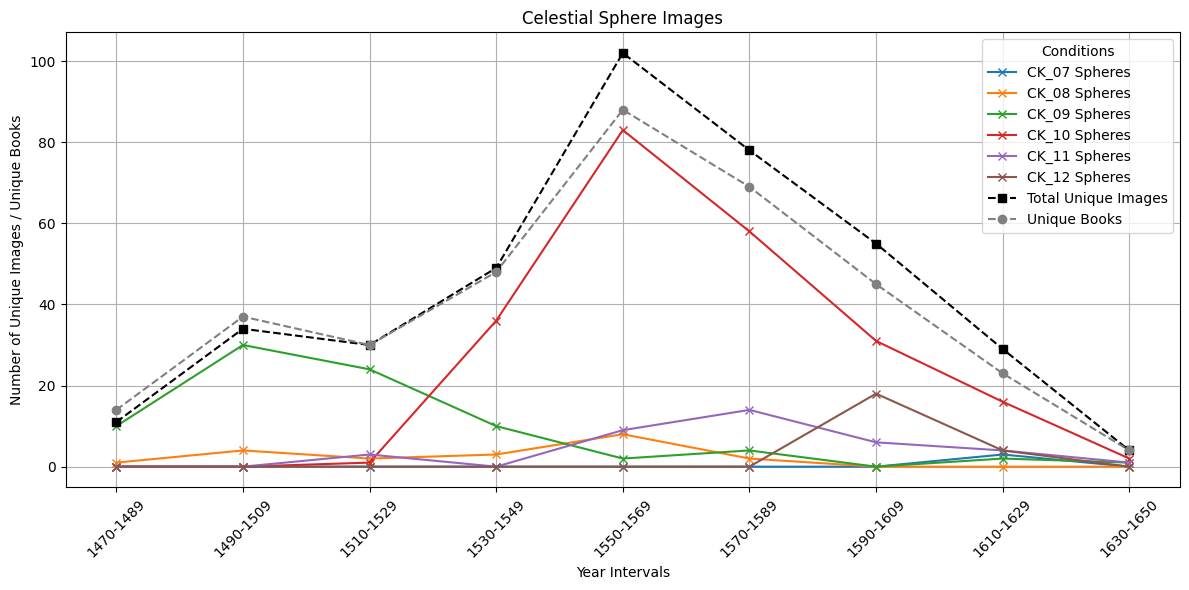

In [10]:
# Ensure filtered_df and books are treated as copies (if required)
filtered_df = filtered_df.copy()
books = books.copy()

# Ensure 'year' columns are of integer type
filtered_df['year'] = filtered_df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650'
]

# Add 'interval' column to the filtered_df DataFrame based on custom bins
filtered_df['interval'] = pd.cut(filtered_df['year'], bins=bins, labels=labels, right=False)

# Add 'interval' column to the books DataFrame
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define the keywords for the 'cks' values
keywords = ['CK_07 Spheres', 'CK_08 Spheres', 'CK_09 Spheres', 'CK_10 Spheres', 'CK_11 Spheres', 'CK_12 Spheres']

# Count unique images by keywords in filtered_df
unique_images_by_keyword = {}
for keyword in keywords:
    condition = filtered_df['cks'].apply(lambda x: keyword in x)
    unique_images_by_keyword[keyword] = filtered_df[condition].groupby('interval', observed=False)['images'].nunique()

# Count the total number of unique images across all `cks` values
total_unique_images = filtered_df.groupby('interval', observed=False)['images'].nunique()

# Count unique books by interval in the books DataFrame
unique_books_count = books.groupby('interval', observed=False)['book'].nunique()

# Step 3: Plot the results
plt.figure(figsize=(12, 6))

# Plot unique images for each keyword
for keyword, unique_images in unique_images_by_keyword.items():
    plt.plot(unique_images.index.astype(str), unique_images.values, label=keyword, marker='x')

# Plot the total unique images as a dashed line
plt.plot(total_unique_images.index.astype(str), total_unique_images.values, label='Total Unique Images', marker='s', color='black', linestyle='--')

# Plot the number of unique books as a dashed grey line
plt.plot(unique_books_count.index.astype(str), unique_books_count.values, label='Unique Books', marker='o', color='grey', linestyle='--')

# Customize the plot
plt.title('Celestial Sphere Images')
plt.xlabel('Year Intervals')
plt.ylabel('Number of Unique Images / Unique Books')
plt.xticks(rotation=45)
plt.legend(title='Conditions')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
# Define the updated mapping of places to categories
place_categories = {
    'Venice': 'Large centers',
    'Paris': 'Large centers',
    'Wittenberg': 'Large centers',
    'Antwerp': 'Medium centers',
    'Leipzig': 'Medium centers',
    'Frankfurt (Main)': 'Medium centers',
    'Lyon': 'Medium centers',
    'Cologne': 'Medium centers',
    'London': 'Medium centers',
    'Rome': 'Small centers',
    'Strasbourg': 'Small centers',
    'Seville': 'Small centers',
    'Leiden': 'Small centers',
    'Milan': 'Small centers',
    'Saint Gervais': 'Small centers',
    'Florence': 'Small centers',
    'Kraków': 'Small centers',
    'Salamanca': 'Small centers',
    'Lisbon': 'Small centers',
    'Bologna': 'Small centers',
    'Madrid': 'Small centers',
    'Sine loco': 'Small centers',
    'Basel': 'Small centers',
    'Lemgo': 'Small centers',
    'Dijon': 'Small centers',
    'Valladolid': 'Small centers',
    'Perugia': 'Small centers',
    'Siena': 'One book centers',
    'Avignon': 'One book centers',
    'Vienna': 'One book centers',
    'Ferrara': 'One book centers',
    'Padua': 'One book centers',
    'Nuremberg': 'One book centers',
    'Neustadt an der Weinstraße': 'One book centers',
    'Mexico City': 'One book centers',
    'Mainz': 'One book centers',
    'Coimbra': 'One book centers',
    'Leuven': 'One book centers',
    'Ingolstadt': 'One book centers',
    'Heidelberg': 'One book centers',
    'Geneva': 'One book centers',
    'Dillingen an der Donau': 'One book centers',
    'Alcalá de Henares': 'One book centers'
}

# Ensure 'place' column exists in merged_df and is in the format we expect
filtered_df['place'] = filtered_df['place'].astype(str)

# Create the 'place_category' column by mapping the 'place' column to categories
filtered_df['place_category'] = filtered_df['place'].map(place_categories)

# Group by 'place_category' and count the number of unique 'book' values and unique 'place' values in each category
unique_books_and_places_per_category = filtered_df.groupby('place_category').agg(
    unique_books_count=('book', 'nunique'),
    unique_places_count=('place', 'nunique')
).reset_index()

# Print the unique place categories, the number of unique books, and the number of unique places
print(unique_books_and_places_per_category)


     place_category  unique_books_count  unique_places_count
0     Large centers                 170                    3
1    Medium centers                  83                    6
2  One book centers                  14                   14
3     Small centers                  47                   18


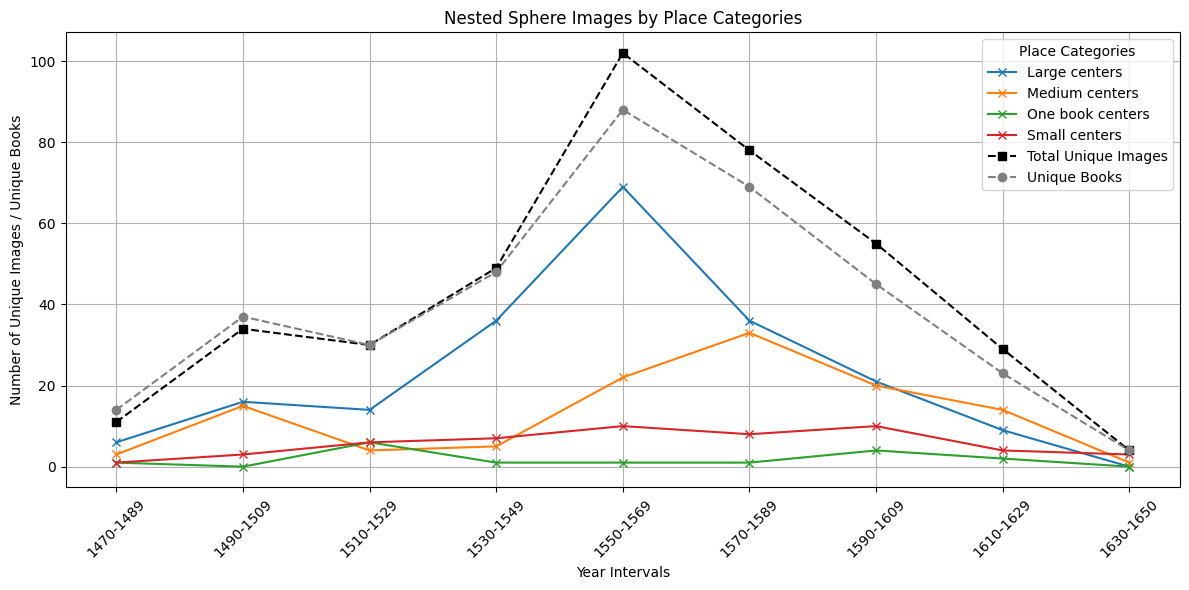

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure filtered_df and books are treated as copies (if required)
filtered_df = filtered_df.copy()
books = books.copy()

# Ensure 'year' columns are of integer type
filtered_df['year'] = filtered_df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650'
]

# Add 'interval' column to the filtered_df DataFrame based on custom bins
filtered_df['interval'] = pd.cut(filtered_df['year'], bins=bins, labels=labels, right=False)

# Add 'interval' column to the books DataFrame
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Count unique images by interval and place_category in filtered_df
unique_images_by_place = filtered_df.groupby(['interval', 'place_category'], observed=False)['images'].nunique().unstack(fill_value=0)

# Count the total number of unique images across all place categories for each interval
total_unique_images = filtered_df.groupby('interval', observed=False)['images'].nunique()

# Count unique books by interval in the books DataFrame
unique_books_count = books.groupby('interval', observed=False)['book'].nunique()

# Step 3: Plot the results
plt.figure(figsize=(12, 6))

# Plot unique images for each place category
for place_category in unique_images_by_place.columns:
    plt.plot(unique_images_by_place.index.astype(str), unique_images_by_place[place_category], label=place_category, marker='x')

# Plot the total unique images as a dashed line
plt.plot(total_unique_images.index.astype(str), total_unique_images.values, label='Total Unique Images', marker='s', color='black', linestyle='--')

# Plot the number of unique books as a dashed grey line
plt.plot(unique_books_count.index.astype(str), unique_books_count.values, label='Unique Books', marker='o', color='grey', linestyle='--')

# Customize the plot
plt.title('Nested Sphere Images by Place Categories')
plt.xlabel('Year Intervals')
plt.ylabel('Number of Unique Images / Unique Books')
plt.xticks(rotation=45)
plt.legend(title='Place Categories')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


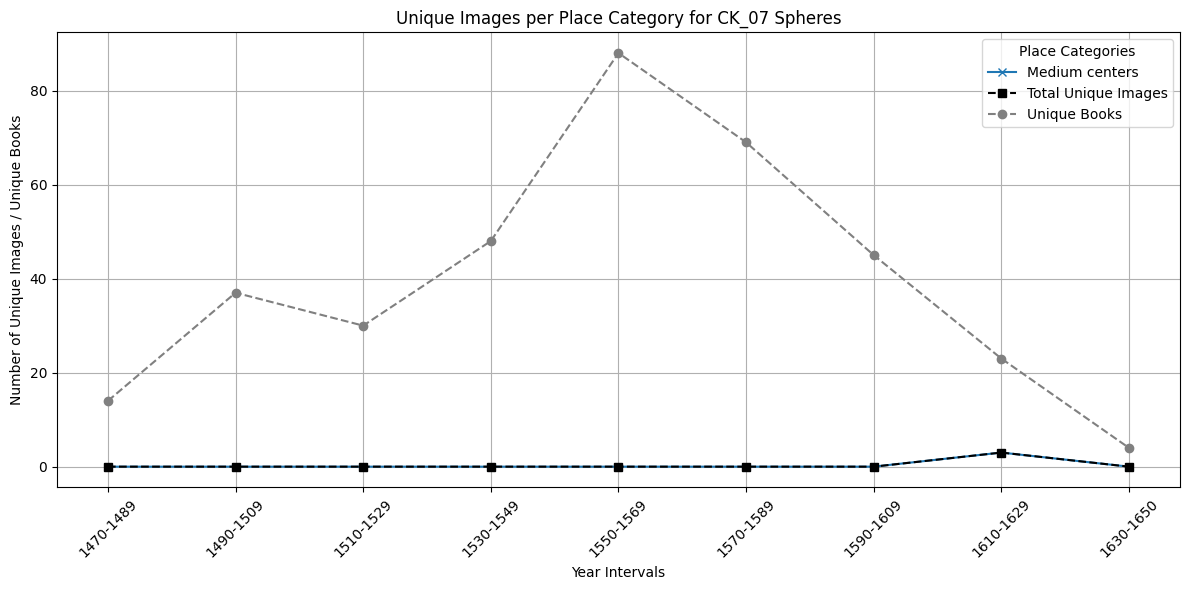

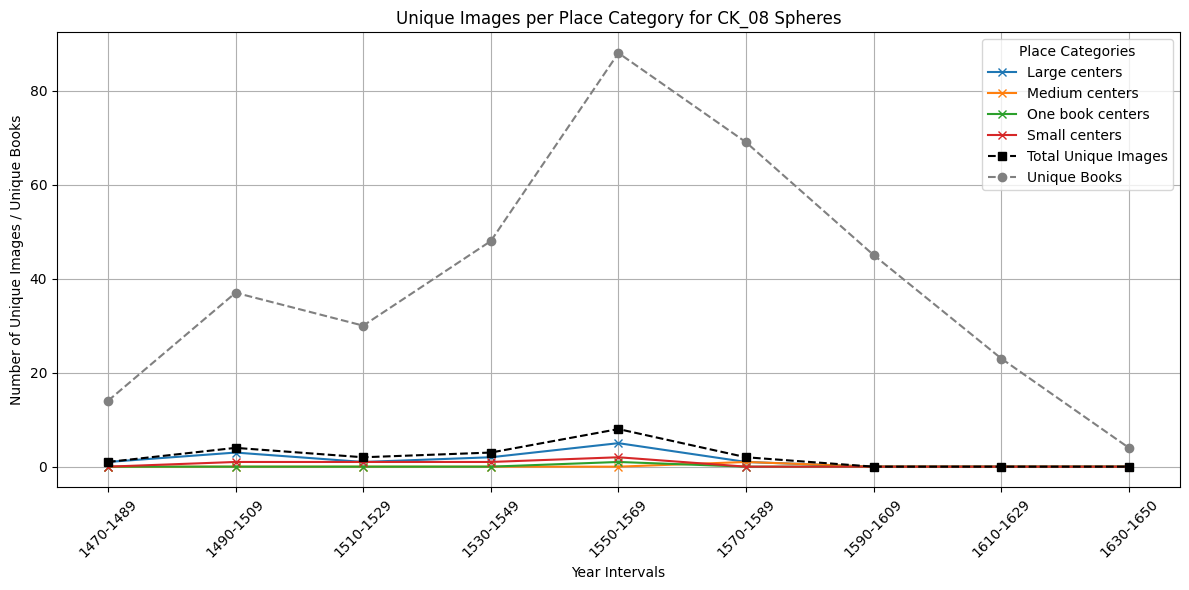

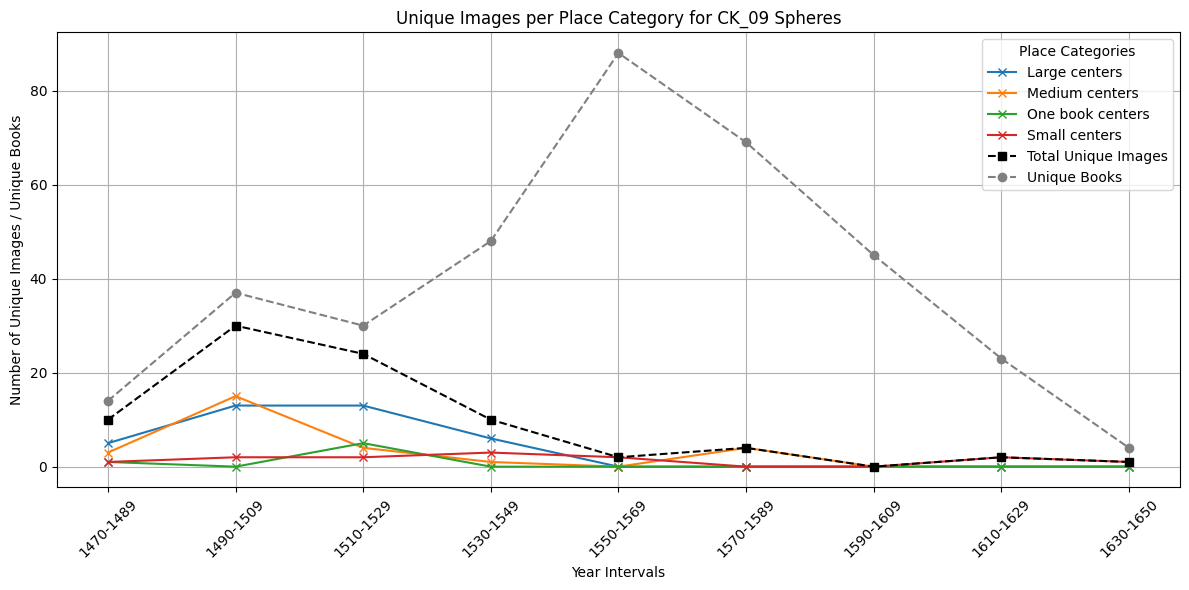

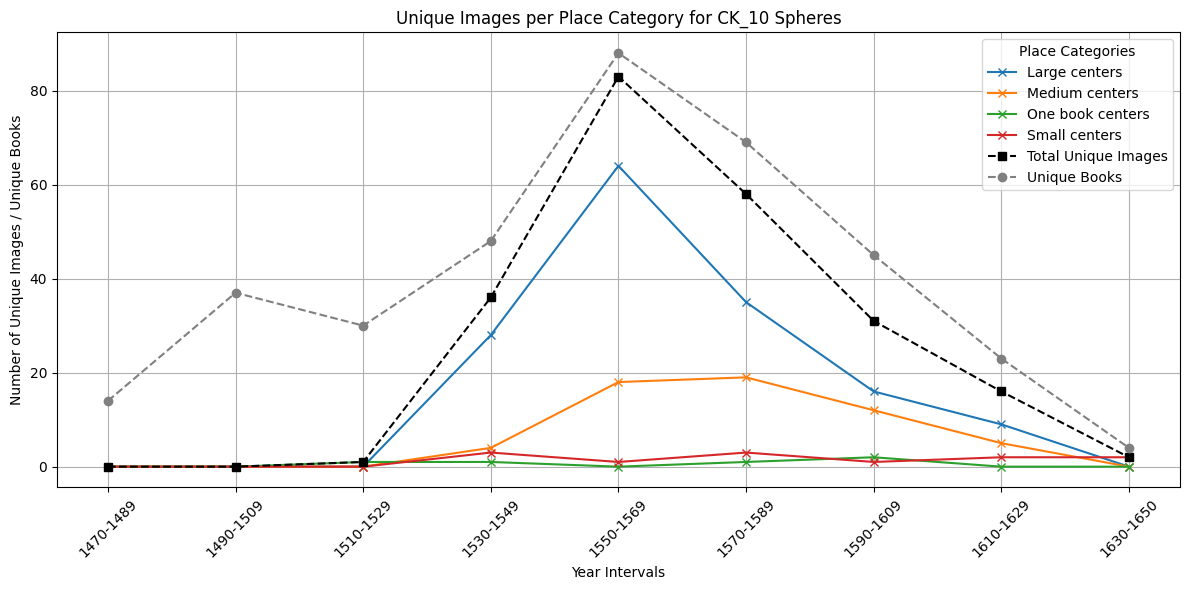

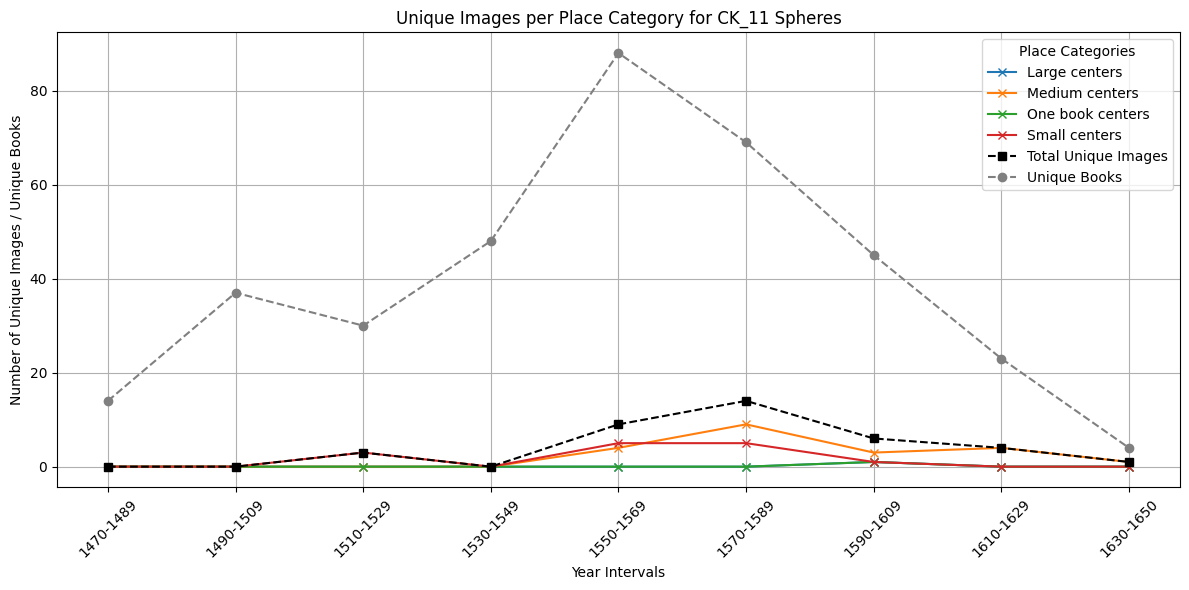

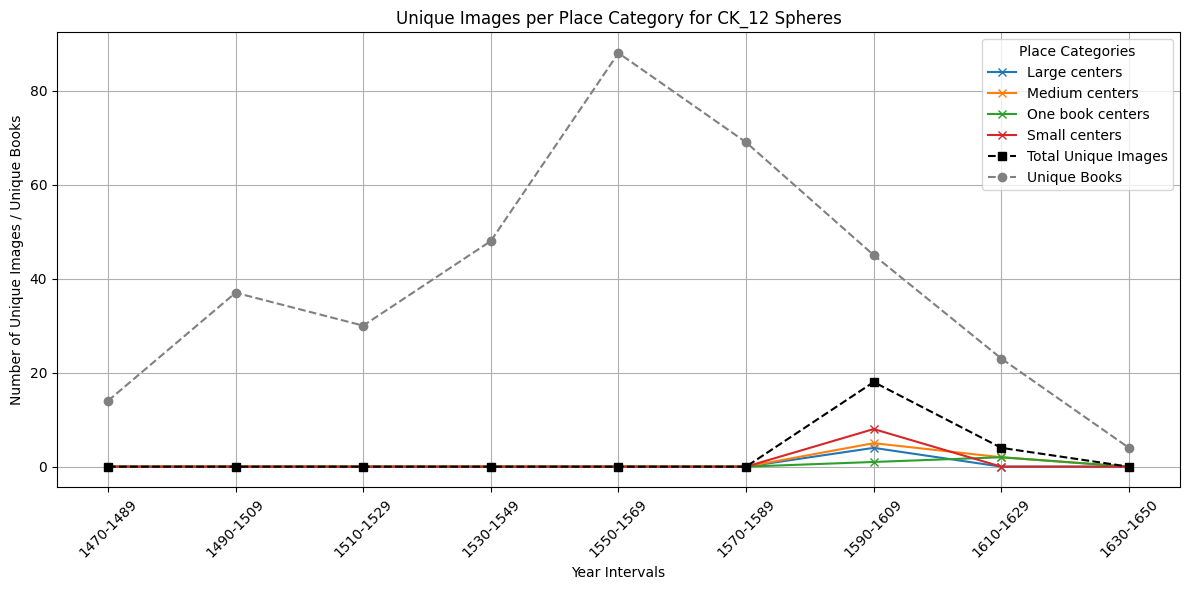

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure filtered_df and books are treated as copies (if required)
filtered_df = filtered_df.copy()
books = books.copy()

# Ensure 'year' columns are of integer type
filtered_df['year'] = filtered_df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650'
]

# Add 'interval' column to the filtered_df DataFrame based on custom bins
filtered_df['interval'] = pd.cut(filtered_df['year'], bins=bins, labels=labels, right=False)

# Add 'interval' column to the books DataFrame
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define the keywords for the 'cks' values
keywords = ['CK_07 Spheres', 'CK_08 Spheres', 'CK_09 Spheres', 'CK_10 Spheres', 'CK_11 Spheres', 'CK_12 Spheres']

# Step 1: Plot the results for each unique `cks` value
for keyword in keywords:
    # Step 2: Filter the filtered_df DataFrame for the current keyword
    condition = filtered_df['cks'].apply(lambda x: keyword in x)
    filtered_keyword_df = filtered_df[condition]
    
    # Count unique images by interval and place_category for the current keyword
    unique_images_by_place = filtered_keyword_df.groupby(['interval', 'place_category'], observed=False)['images'].nunique().unstack(fill_value=0)
    
    # Count the total number of unique images across all place categories for each interval for the current keyword
    total_unique_images = filtered_keyword_df.groupby('interval', observed=False)['images'].nunique()

    # Count unique books by interval in the books DataFrame for the current keyword
    unique_books_count = books.groupby('interval', observed=False)['book'].nunique()

    # Step 3: Plot the results for the current keyword
    plt.figure(figsize=(12, 6))

    # Plot unique images for each place category
    for place_category in unique_images_by_place.columns:
        plt.plot(unique_images_by_place.index.astype(str), unique_images_by_place[place_category], label=place_category, marker='x')

    # Plot the total unique images as a dashed line
    plt.plot(total_unique_images.index.astype(str), total_unique_images.values, label='Total Unique Images', marker='s', color='black', linestyle='--')

    # Plot the number of unique books as a dashed grey line
    plt.plot(unique_books_count.index.astype(str), unique_books_count.values, label='Unique Books', marker='o', color='grey', linestyle='--')

    # Customize the plot
    plt.title(f'Unique Images per Place Category for {keyword}')
    plt.xlabel('Year Intervals')
    plt.ylabel('Number of Unique Images / Unique Books')
    plt.xticks(rotation=45)
    plt.legend(title='Place Categories')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


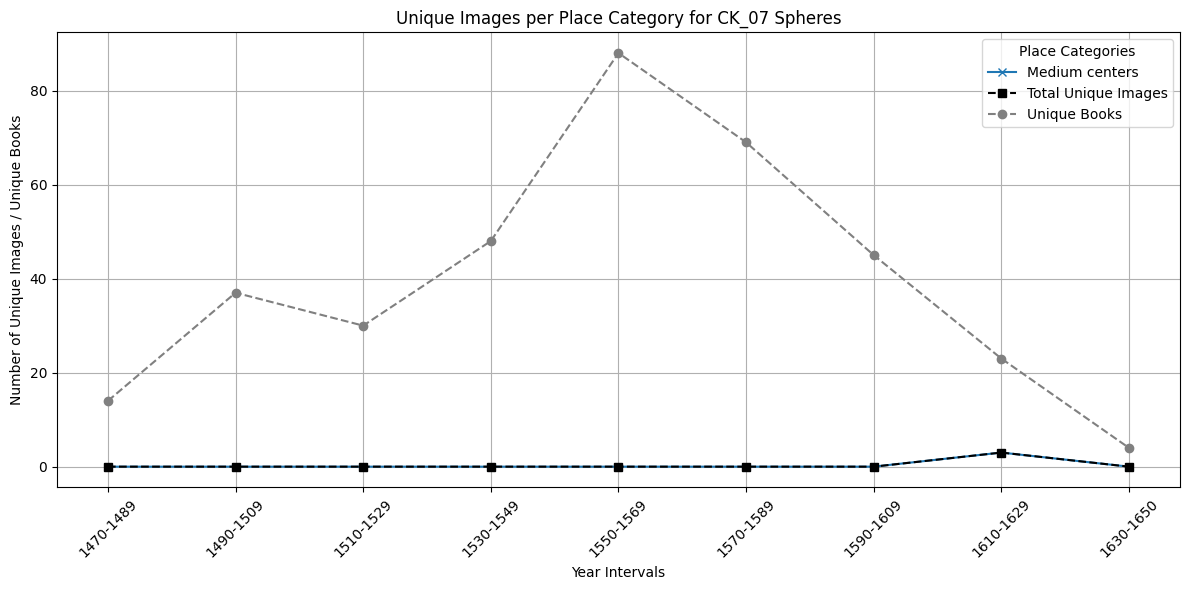

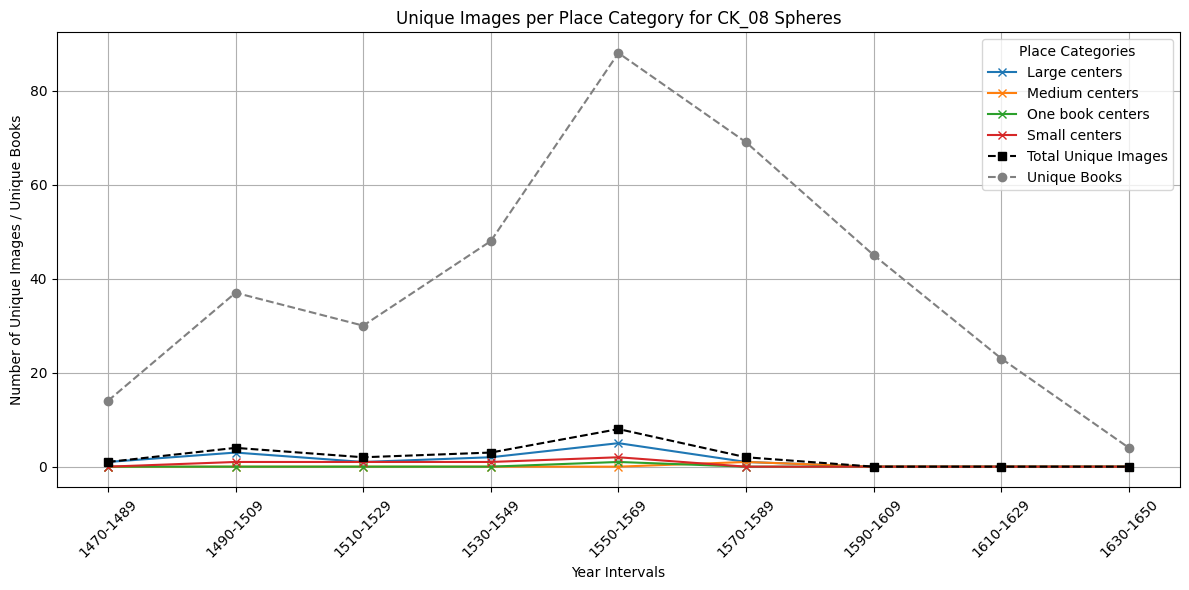

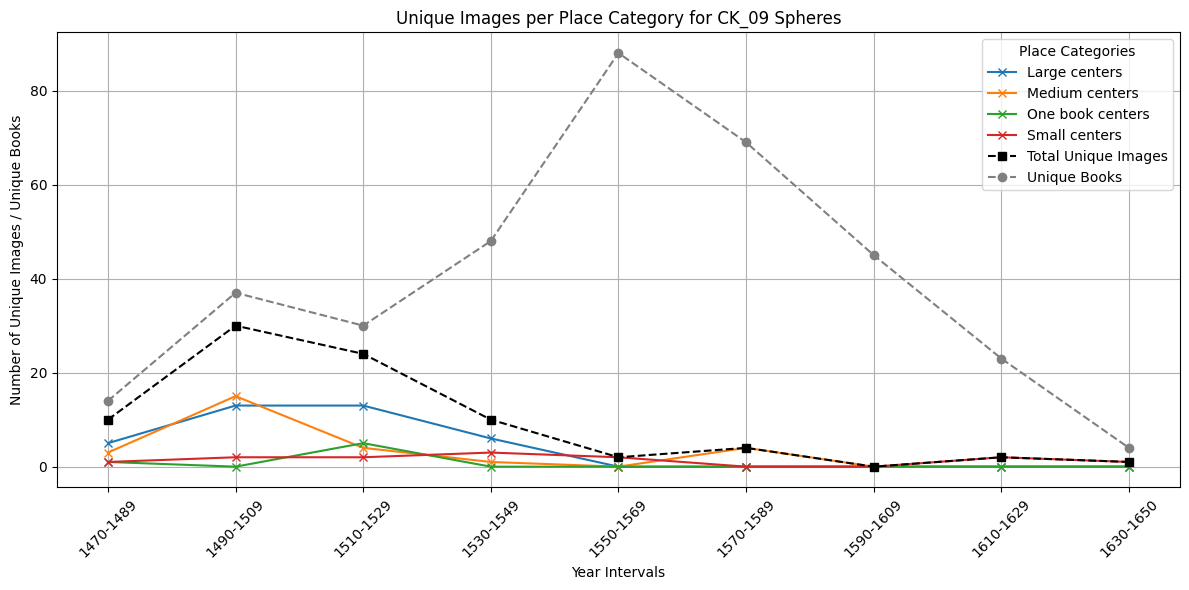

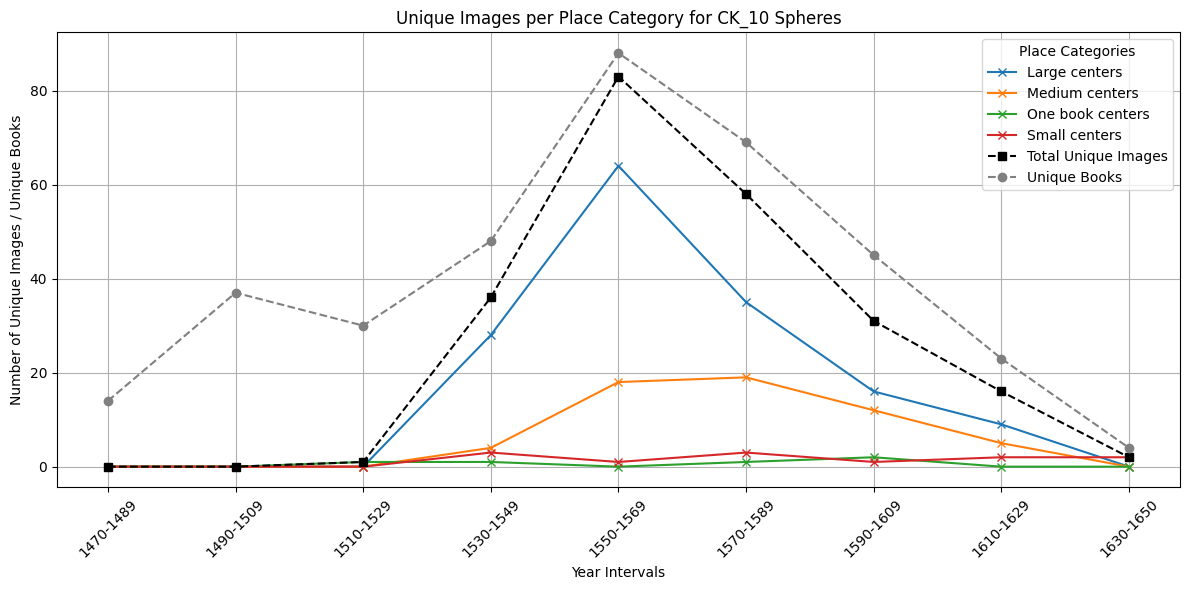

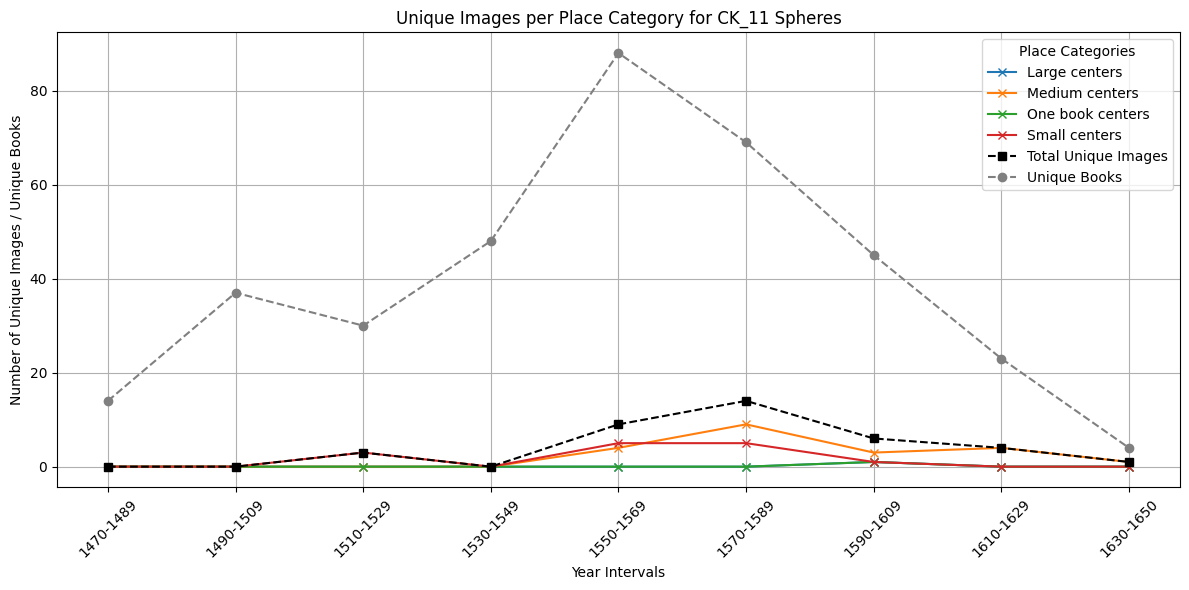

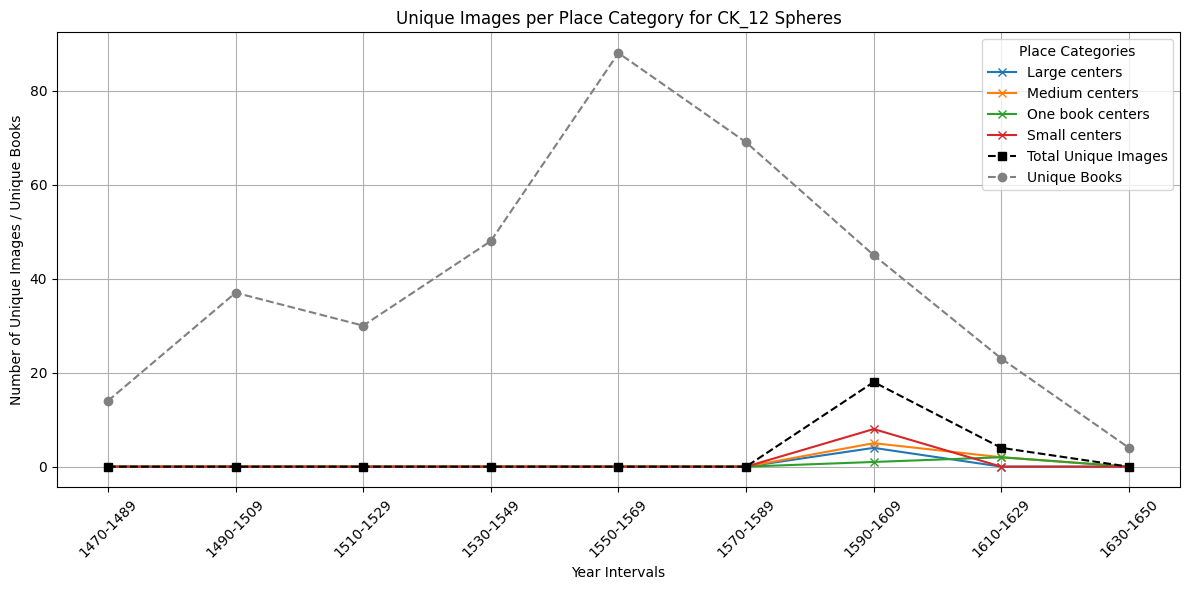

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure filtered_df and books are treated as copies (if required)
filtered_df = filtered_df.copy()
books = books.copy()

# Ensure 'year' columns are of integer type
filtered_df['year'] = filtered_df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650'
]

# Add 'interval' column to the filtered_df DataFrame based on custom bins
filtered_df['interval'] = pd.cut(filtered_df['year'], bins=bins, labels=labels, right=False)

# Add 'interval' column to the books DataFrame
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define the keywords for the 'cks' values
keywords = ['CK_07 Spheres', 'CK_08 Spheres', 'CK_09 Spheres', 'CK_10 Spheres', 'CK_11 Spheres', 'CK_12 Spheres']

# Step 1: Plot the results for each unique `cks` value
for keyword in keywords:
    # Step 2: Filter the filtered_df DataFrame for the current keyword
    condition = filtered_df['cks'].apply(lambda x: keyword in x)
    filtered_keyword_df = filtered_df[condition]
    
    # Count unique images by interval and place_category for the current keyword
    unique_images_by_place = filtered_keyword_df.groupby(['interval', 'place_category'], observed=False)['images'].nunique().unstack(fill_value=0)
    
    # Count the total number of unique images across all place categories for each interval for the current keyword
    total_unique_images = filtered_keyword_df.groupby('interval', observed=False)['images'].nunique()

    # Count unique books by interval in the books DataFrame for the current keyword
    unique_books_count = books.groupby('interval', observed=False)['book'].nunique()

    # Step 3: Plot the results for the current keyword
    plt.figure(figsize=(12, 6))

    # Plot unique images for each place category
    for place_category in unique_images_by_place.columns:
        plt.plot(unique_images_by_place.index.astype(str), unique_images_by_place[place_category], label=place_category, marker='x')

    # Plot the total unique images as a dashed line
    plt.plot(total_unique_images.index.astype(str), total_unique_images.values, label='Total Unique Images', marker='s', color='black', linestyle='--')

    # Plot the number of unique books as a dashed grey line
    plt.plot(unique_books_count.index.astype(str), unique_books_count.values, label='Unique Books', marker='o', color='grey', linestyle='--')

    # Customize the plot
    plt.title(f'Unique Images per Place Category for {keyword}')
    plt.xlabel('Year Intervals')
    plt.ylabel('Number of Unique Images / Unique Books')
    plt.xticks(rotation=45)
    plt.legend(title='Place Categories')
    plt.grid(True)

    # Save the plot as an image
    output_filename = f"{keyword}_unique_images_per_place_category.png"
    plt.tight_layout()
    plt.savefig(output_filename)

    # Optionally, show the plot
    plt.show()


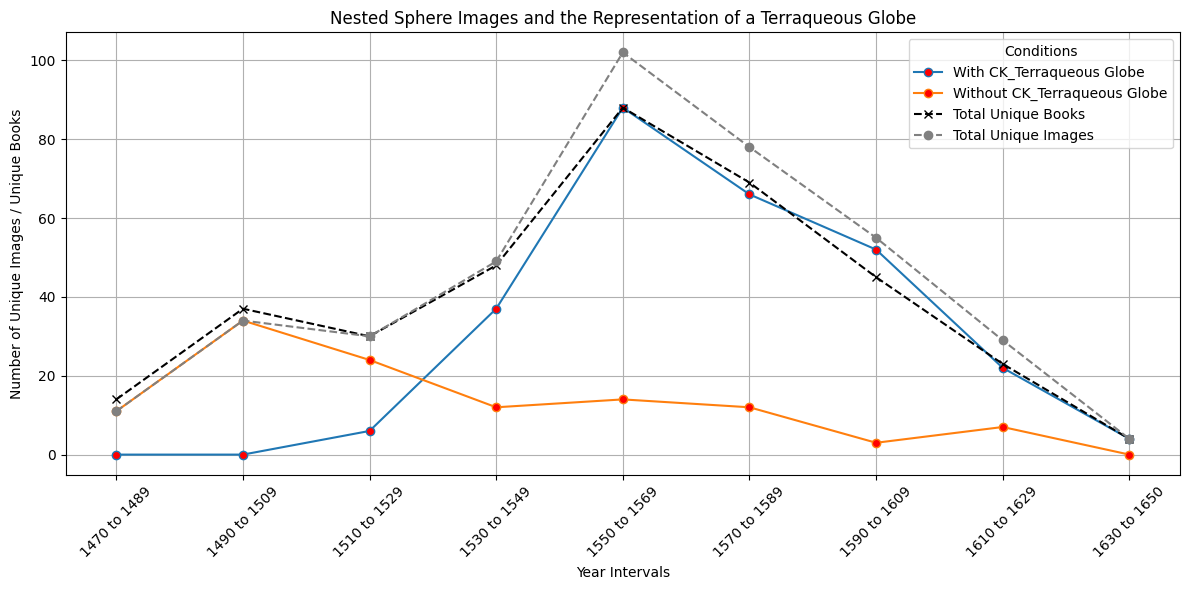

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure filtered_df and books are treated as copies (if required)
filtered_df = filtered_df.copy()
books = books.copy()

# Ensure 'year' columns are of integer type
filtered_df['year'] = filtered_df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650'
]

# Add 'interval' column to the filtered_df DataFrame based on custom bins
filtered_df['interval'] = pd.cut(filtered_df['year'], bins=bins, labels=labels, right=False)

# Step 1: Create a new DataFrame with unique images
unique_images_df = filtered_df.drop_duplicates(subset=['images']).copy()  # Explicit copy here

# Step 2: Create the "terraqueous_globe" column using .loc[] to avoid SettingWithCopyWarning
unique_images_df['terraqueous_globe'] = unique_images_df['images'].apply(
    lambda x: 'CK_Terraqueous Globe' in filtered_df[filtered_df['images'] == x]['cks'].values
)

# Step 3: Replace True/False with custom labels in "terraqueous_globe" column
unique_images_df['terraqueous_globe'] = unique_images_df['terraqueous_globe'].replace(
    {True: 'With CK_Terraqueous Globe', False: 'Without CK_Terraqueous Globe'}
)

# Step 4: Count the unique images for each interval and "terraqueous_globe" status
image_counts = unique_images_df.groupby(['interval', 'terraqueous_globe'], observed=False)['images'].nunique().unstack(fill_value=0)

# Change the index name (title) to something more descriptive
image_counts.index.name = 'Year Interval'

# Optionally, change the index labels to a more readable format
image_counts.index = image_counts.index.str.replace('-', ' to ')

# Step 5: Count the total number of unique books by interval
unique_books_count = books.groupby('interval', observed=False)['book'].nunique()

# Step 6: Count the total number of unique images by interval in filtered_df
unique_images_total_count = filtered_df.groupby('interval', observed=False)['images'].nunique()

# Step 7: Plot the results
plt.figure(figsize=(12, 6))

# Plot the unique images for "CK_Terraqueous Globe" and non-"CK_Terraqueous Globe"
image_counts.plot(kind='line', marker='o', ax=plt.gca(), linestyle='-', markerfacecolor='red')

# Plot the total number of unique books (black dashed line)
plt.plot(unique_books_count.index.astype(str), unique_books_count.values, label='Total Unique Books', color='black', linestyle='--', marker='x')

# Plot the total number of unique images (grey dashed line)
plt.plot(unique_images_total_count.index.astype(str), unique_images_total_count.values, label='Total Unique Images', color='grey', linestyle='--', marker='o')

# Customize the plot
plt.title('Nested Sphere Images and the Representation of a Terraqueous Globe')
plt.xlabel('Year Intervals')
plt.ylabel('Number of Unique Images / Unique Books')
plt.xticks(rotation=45)
plt.legend(title='Conditions')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
# Filter the DataFrame into two based on the unique values in the "terraqueous_globe" column
with_terraqueous_df = unique_images_df[unique_images_df['terraqueous_globe'] == 'With CK_Terraqueous Globe']
without_terraqueous_df = unique_images_df[unique_images_df['terraqueous_globe'] == 'Without CK_Terraqueous Globe']

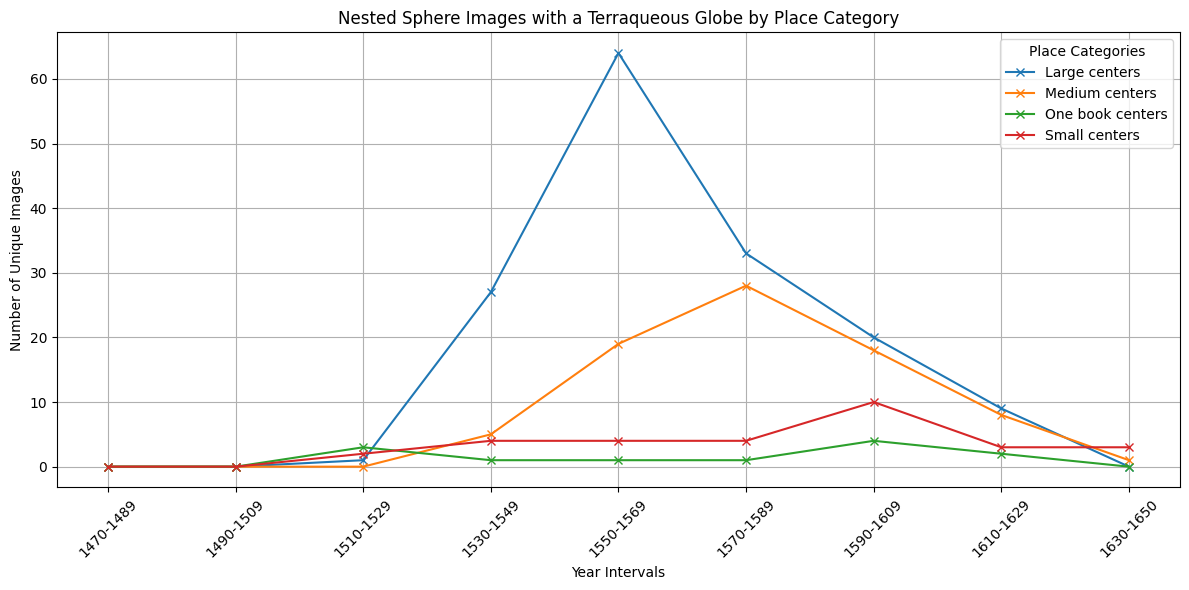

In [17]:
import matplotlib.pyplot as plt

# Group the with_terraqueous_df by 'interval' and 'place_category' and count unique 'images'
image_counts_with_terraqueous = with_terraqueous_df.groupby(['interval', 'place_category'], observed=True)['images'].nunique().unstack(fill_value=0)

# Ensure all intervals from 1470 to 1650 are included, even if they have no data
# Manually specify the full list of intervals we expect to see
all_intervals = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650']

# Reindex the DataFrame to include all intervals
image_counts_with_terraqueous = image_counts_with_terraqueous.reindex(all_intervals, fill_value=0)

# Plotting the results
plt.figure(figsize=(12, 6))

# Loop through each place_category to plot a line for each
for place_category in image_counts_with_terraqueous.columns:
    plt.plot(image_counts_with_terraqueous.index.astype(str), image_counts_with_terraqueous[place_category], label=place_category, marker='x')

# Customize the plot
plt.title('Nested Sphere Images with a Terraqueous Globe by Place Category')
plt.xlabel('Year Intervals')
plt.ylabel('Number of Unique Images')
plt.xticks(rotation=45)
plt.legend(title='Place Categories')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


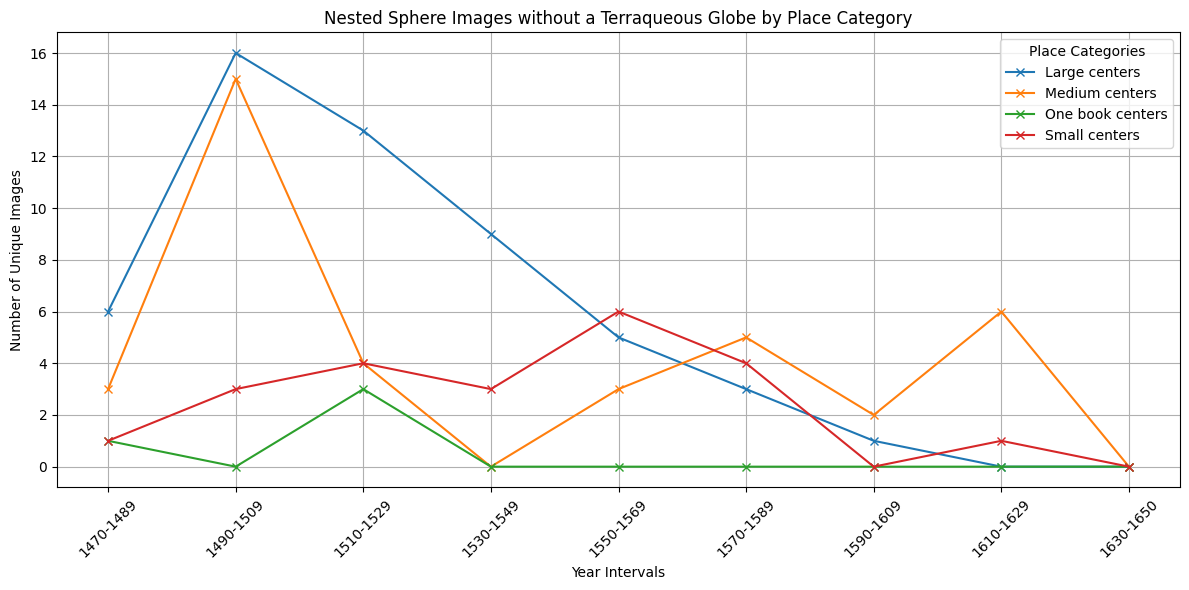

In [18]:
import matplotlib.pyplot as plt

# Group the without_terraqueous_df by 'interval' and 'place_category' and count unique 'images'
# Ensure 'observed=True' to avoid the FutureWarning
image_counts_without_terraqueous = without_terraqueous_df.groupby(['interval', 'place_category'], observed=True)['images'].nunique().unstack(fill_value=0)

# Ensure all intervals from 1470 to 1650 are included, even if they have no data
# Manually specify the full list of intervals we expect to see
all_intervals = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650']

# Reindex the DataFrame to include all intervals
image_counts_without_terraqueous = image_counts_without_terraqueous.reindex(all_intervals, fill_value=0)

# Plotting the results
plt.figure(figsize=(12, 6))

# Loop through each place_category to plot a line for each
for place_category in image_counts_without_terraqueous.columns:
    plt.plot(image_counts_without_terraqueous.index.astype(str), image_counts_without_terraqueous[place_category], label=place_category, marker='x')

# Customize the plot
plt.title('Nested Sphere Images without a Terraqueous Globe by Place Category')
plt.xlabel('Year Intervals')
plt.ylabel('Number of Unique Images')
plt.xticks(rotation=45)
plt.legend(title='Place Categories')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


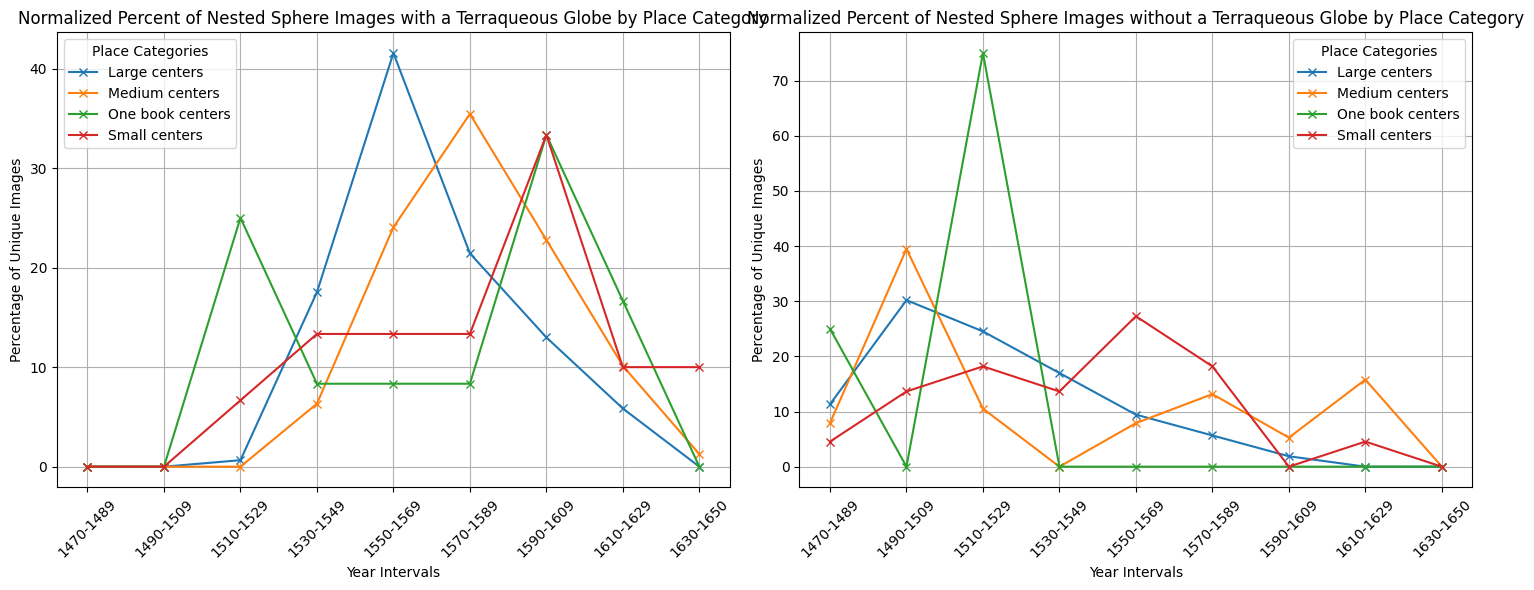

In [19]:
import matplotlib.pyplot as plt

# Group the with_terraqueous_df by 'interval' and 'place_category' and count unique 'images'
image_counts_with_terraqueous = with_terraqueous_df.groupby(['interval', 'place_category'], observed=True)['images'].nunique().unstack(fill_value=0)

# Ensure all intervals from 1470 to 1650 are included, even if they have no data
all_intervals = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1650']
image_counts_with_terraqueous = image_counts_with_terraqueous.reindex(all_intervals, fill_value=0)

# Normalize the image counts to percentages for 'with Terraqueous'
for place_category in image_counts_with_terraqueous.columns:
    total_images = image_counts_with_terraqueous[place_category].sum()
    image_counts_with_terraqueous[place_category] = (image_counts_with_terraqueous[place_category] / total_images) * 100

# Group the without_terraqueous_df by 'interval' and 'place_category' and count unique 'images'
image_counts_without_terraqueous = without_terraqueous_df.groupby(['interval', 'place_category'], observed=True)['images'].nunique().unstack(fill_value=0)

# Ensure all intervals from 1470 to 1650 are included, even if they have no data
image_counts_without_terraqueous = image_counts_without_terraqueous.reindex(all_intervals, fill_value=0)

# Normalize the image counts to percentages for 'without Terraqueous'
for place_category in image_counts_without_terraqueous.columns:
    total_images = image_counts_without_terraqueous[place_category].sum()
    image_counts_without_terraqueous[place_category] = (image_counts_without_terraqueous[place_category] / total_images) * 100

# Create two subplots for displaying the two graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the results for 'with Terraqueous Globe'
for place_category in image_counts_with_terraqueous.columns:
    axes[0].plot(image_counts_with_terraqueous.index.astype(str), image_counts_with_terraqueous[place_category], label=place_category, marker='x')

# Customize the first plot
axes[0].set_title('Normalized Percent of Nested Sphere Images with a Terraqueous Globe by Place Category')
axes[0].set_xlabel('Year Intervals')
axes[0].set_ylabel('Percentage of Unique Images')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Place Categories')
axes[0].grid(True)

# Plotting the results for 'without Terraqueous Globe'
for place_category in image_counts_without_terraqueous.columns:
    axes[1].plot(image_counts_without_terraqueous.index.astype(str), image_counts_without_terraqueous[place_category], label=place_category, marker='x')

# Customize the second plot
axes[1].set_title('Normalized Percent of Nested Sphere Images without a Terraqueous Globe by Place Category')
axes[1].set_xlabel('Year Intervals')
axes[1].set_ylabel('Percentage of Unique Images')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Place Categories')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
# Define the city_position dictionary (same as before)
city_position = {
    'Alcalá de Henares': (40.4818396, -3.3644973),
    'Antwerp': (51.2211097, 4.3997081),
    'Augsburg': (48.3690341, 10.8979522),
    'Avignon': (43.9492493, 4.8059012),
    'Basel': (47.5581077, 7.5878261),
    'Bologna': (44.4938203, 11.3426327),
    'Bordeaux': (44.841225, -0.5800364),
    'Coimbra': (40.2111931, -8.4294632),
    'Cologne': (43.7218277, 0.9774958),
    'Dijon': (47.3215806, 5.0414701),
    'Dillingen an der Donau': (48.5812791, 10.4951026),
    'Dortmund': (51.5142273, 7.4652789),
    'Ferrara': (44.8372737, 11.6186451),
    'Florence': (43.7697955, 11.2556404),
    'Frankfurt am Main': (50.1106444, 8.6820917),
    'Frankfurt an der Oder': (52.3412273, 14.549452),
    'Geneva': (46.2047169, 6.1423106290939335),
    'Heidelberg': (49.4093582, 8.694724),
    'Ingolstadt': (48.7630165, 11.4250395),
    'Kraków': (50.0469432, 19.997153435836697),
    'Leiden': (52.1594747, 4.4908843),
    'Leipzig': (51.3406321, 12.3747329),
    'Lemgo': (52.0280674, 8.9012894),
    'Leuven': (50.879202, 4.7011675),
    'Lisbon': (38.7077507, -9.1365919),
    'London': (51.4893335, -0.14405508452768728),
    'Lyon': (45.7578137, 4.8320114),
    'Madrid': (40.4167047, -3.7035825),
    'Mainz': (50.0012314, 8.2762513),
    'Mexico City': (19.4326296, -99.1331785),
    'Milan': (45.4641943, 9.1896346),
    'Neustadt an der Weinstraße': (49.3539802, 8.1350021),
    'Nuremberg': (49.453872, 11.077298),
    'Padua': (45.4077172, 11.8734455),
    'Paris': (48.8534951, 2.3483915),
    'Perugia': (43.1119613, 12.3890104),
    'Pesaro': (43.9098114, 12.9131228),
    'Rome': (41.8933203, 12.4829321),
    'Saint Gervais': (45.2022356, 5.4820229),
    'Salamanca': (40.9651572, -5.6640182),
    'Seville': (37.3886303, -5.9953403),
    'Siena': (43.3185536, 11.3316533),
    'Sine loco': None,
    'Strasbourg': (48.584614, 7.7507127),
    'Tournon': (45.0675156, 4.832852),
    'Tübingen': (48.5236164, 9.0535531),
    'Valladolid': (41.6521328, -4.728562),
    'Venice': (45.4371908, 12.3345898),
    'Vienna': (48.2083537, 16.3725042),
    'Wittenberg': (51.8666527, 12.646761)
}

# Assuming 'merged_df' is your existing DataFrame and has a 'place' column
# Create a function to map the place name to latitude and longitude
def get_coordinates(city):
    return city_position.get(city, (None, None))  # Returns None if city is not found in the dictionary

# Apply the function to create 'latitude' and 'longitude' columns
filtered_df[['latitude', 'longitude']] = filtered_df['place'].apply(lambda city: pd.Series(get_coordinates(city)))

# Display the updated DataFrame
#merged_df

# Drop rows where 'latitude' or 'longitude' is NaN
filtered_df = filtered_df.dropna(subset=['latitude', 'longitude'])

filtered_df

images   cluster_name  \
64     http://db.sphaera.mpiwg-berlin.mpg.de/containe...  SAC_SIL_00866   
109    http://dev.sphaera.mpiwg-berlin.mpg.de/contain...  SAC_SIL_03903   
160    http://dev.sphaera.mpiwg-berlin.mpg.de/contain...  SAC_SIL_00696   
161    http://dev.sphaera.mpiwg-berlin.mpg.de/contain...  SAC_SIL_00696   
205    http://db.sphaera.mpiwg-berlin.mpg.de/containe...  SAC_SIL_01992   
...                                                  ...            ...   
27884  http://dev.sphaera.mpiwg-berlin.mpg.de/contain...  SAC_SIL_01861   
27908  http://dev.sphaera.mpiwg-berlin.mpg.de/contain...  SAC_SIL_01861   
27911  http://dev.sphaera.mpiwg-berlin.mpg.de/contain...  SAC_SIL_01861   
27936  http://www.researchspace.org/ontology/ImageReg...  SAC_SIL_02035   
27937  http://www.researchspace.org/ontology/ImageReg...  SAC_SIL_02035   

                        cks  \
64            CK_09 Spheres   
109           CK_09 Spheres   
160           CK_09 Spheres   
161             CK_T-O Maps   
205           CK_09 Spheres   
...                     ...   
27884         CK_11 Spheres   
27908         CK_11 Spheres   
27911         CK_11 Spheres   
27936         CK_10 Spheres   
27937  CK_Terraqueous Globe   

                                                    book   bid  \
64     http://sphaera.mpiwg-berlin.mpg.de/id/item/116...  2200   
109    http://sphaera.mpiwg-berlin.mpg.de/id/item/1ae...  1938   
160    http://sphaera.mpiwg-berlin.mpg.de/id/item/5cc...  1928   
161    http://sphaera.mpiwg-berlin.mpg.de/id/item/5cc...  1928   
205    http://sphaera.mpiwg-berlin.mpg.de/id/item/645...  1613   
...                                                  ...   ...   
27884  http://sphaera.mpiwg-berlin.mpg.de/id/item/e76...  2231   
27908  http://sphaera.mpiwg-berlin.mpg.de/id/item/516...  2208   
27911  http://sphaera.mpiwg-berlin.mpg.de/id/item/d7e...  2276   
27936  http://sphaera.mpiwg-berlin.mpg.de/id/item/921...  2277   
27937  http://sphaera.mpiwg-berlin.mpg.de/id/item/921...  2277   

                                        part_or_adaption  \
64     http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...   
109    http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...   
160    http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...   
161    http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...   
205    http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...   
...                                                  ...   
27884  http://sphaera.mpiwg-berlin.mpg.de/id/part/520...   
27908  http://sphaera.mpiwg-berlin.mpg.de/id/part/520...   
27911  http://sphaera.mpiwg-berlin.mpg.de/id/part/520...   
27936  http://sphaera.mpiwg-berlin.mpg.de/id/part/bfb...   
27937  http://sphaera.mpiwg-berlin.mpg.de/id/part/bfb...   

          part_or_adaption_label              type_label custom_identifier  \
64          Tractatus de sphaera  Original Part, Content               100   
109         Tractatus de sphaera  Original Part, Content               100   
160         Tractatus de sphaera  Original Part, Content               100   
161         Tractatus de sphaera  Original Part, Content               100   
205         Tractatus de sphaera  Original Part, Content               100   
...                          ...                     ...               ...   
27884         Sphere by Valerius  Original Part, Content               812   
27908         Sphere by Valerius  Content, Original Part               812   
27911         Sphere by Valerius  Content, Original Part               812   
27936  La Sphere des deux mondes  Content, Original Part               919   
27937  La Sphere des deux mondes  Content, Original Part               919   

         place  year flag   interval    place_category   latitude  longitude  
64     Leipzig  1489  nan  1470-1489    Medium centers  51.340632  12.374733  
109    Ferrara  1472  nan  1470-1489  One book centers  44.837274  11.618645  
160     Venice  1485  nan  1470-1489     Large centers  45.437191  12.334590  
161     V

In [21]:
# Print the number of unique values in the 'images' column
unique_images_count = filtered_df['images'].nunique()
print(f"Number of unique 'images' values: {unique_images_count}")

# Print the unique values in the 'cks' column
unique_cks_values = filtered_df['cks'].unique()
print("Unique 'cks' values:")
print(unique_cks_values)


Number of unique 'images' values: 387
Unique 'cks' values:
['CK_09 Spheres' 'CK_T-O Maps' 'CK_Populated Earth' 'CK_08 Spheres'
 'CK_10 Spheres' 'CK_Terraqueous Globe'
 'CK_Relation Between the Spheres of Water and Earth' 'CK_11 Spheres'
 'CK_Heliocentric Astronomy' 'CK_12 Spheres' 'CK_07 Spheres'
 'CK_Right and Oblique Sphere' 'CK_Parallels'
 'CK_Multiple Celestial Circles']


In [27]:
import pandas as pd

# Assuming filtered_df is already defined

# Step 1: Identify images that have "CK_Terraqueous Globe" in the 'cks' column
images_with_terraqueous = filtered_df[filtered_df['cks'] == 'CK_Terraqueous Globe']['images'].unique()

# Step 2: Create the 'terraqueous_globe' column based on the condition
filtered_df['terraqueous_globe'] = filtered_df['images'].apply(
    lambda x: 'With CK_Terraqueous Globe' if x in images_with_terraqueous else 'Without CK_Terraqueous Globe'
)

#filtered_df

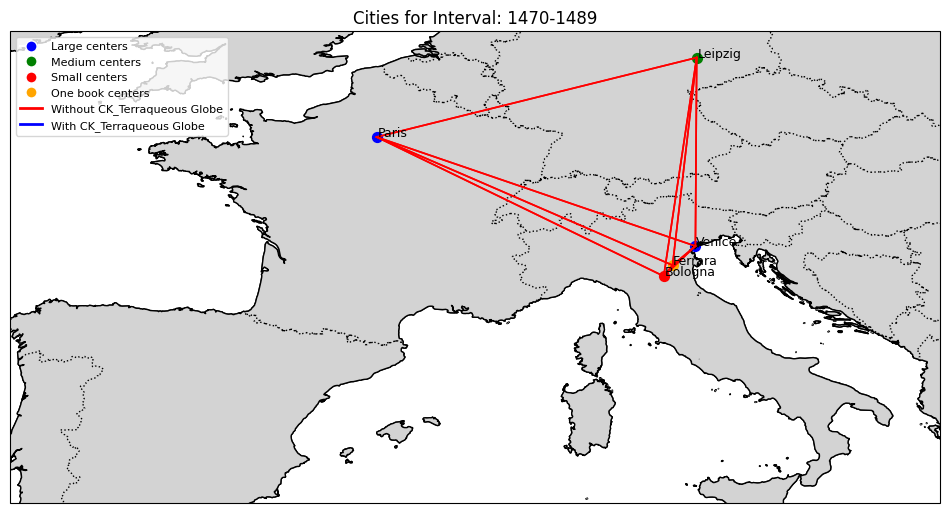

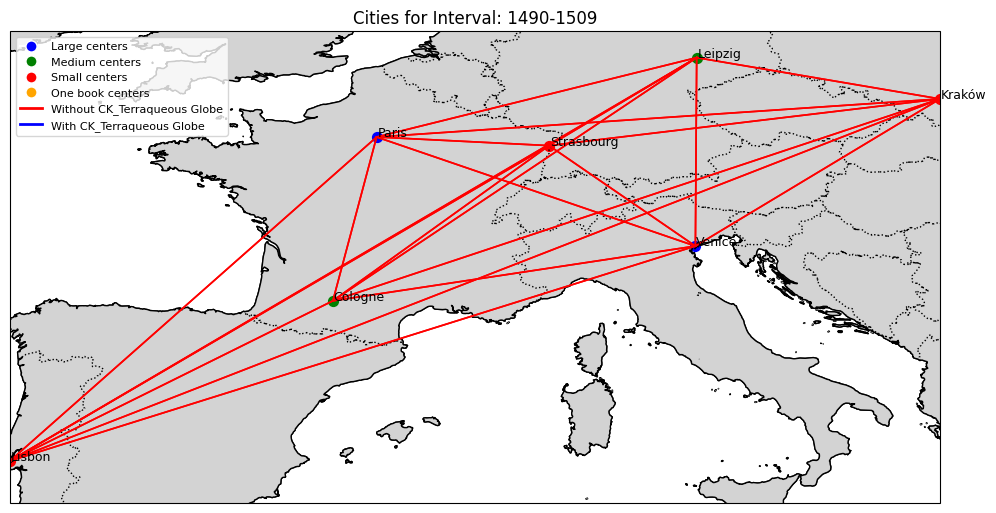

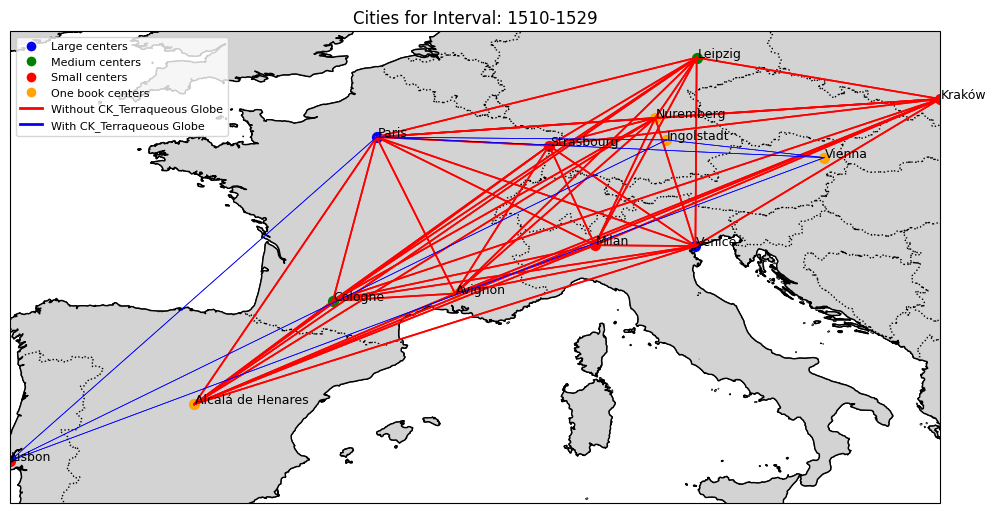

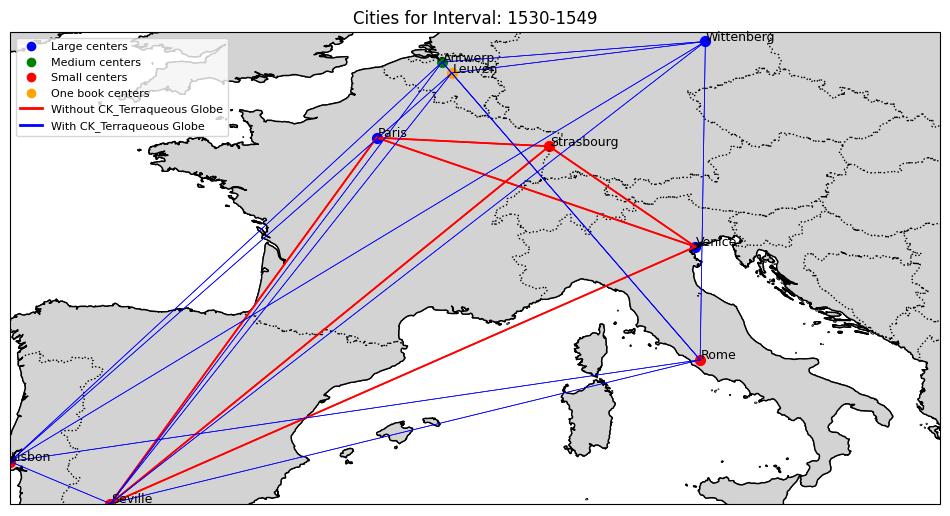

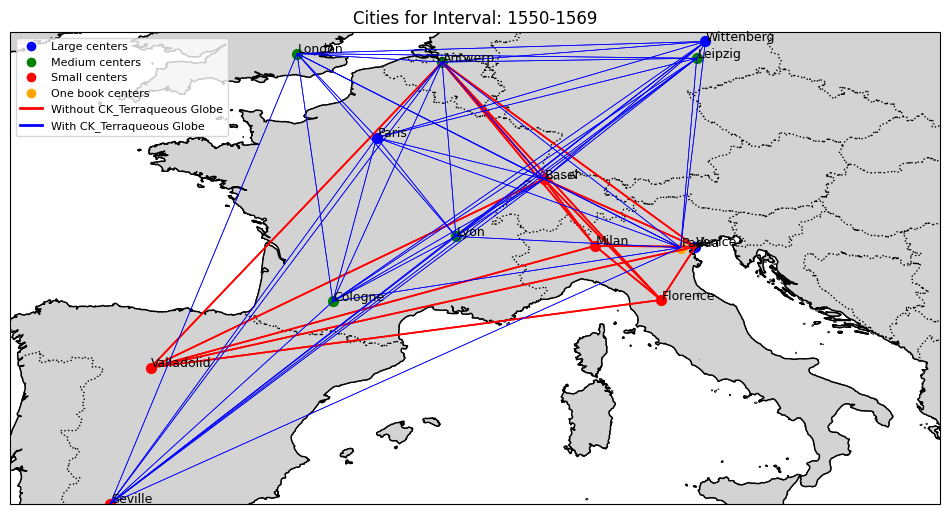

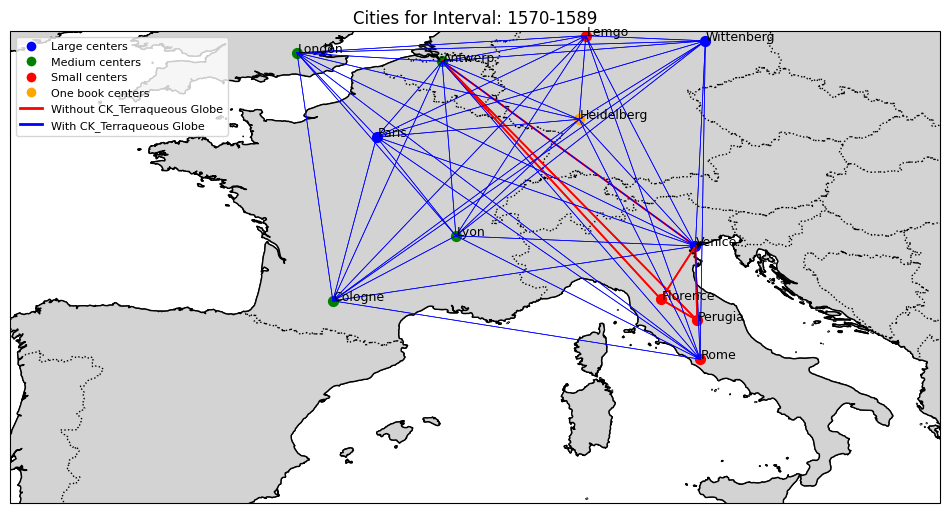

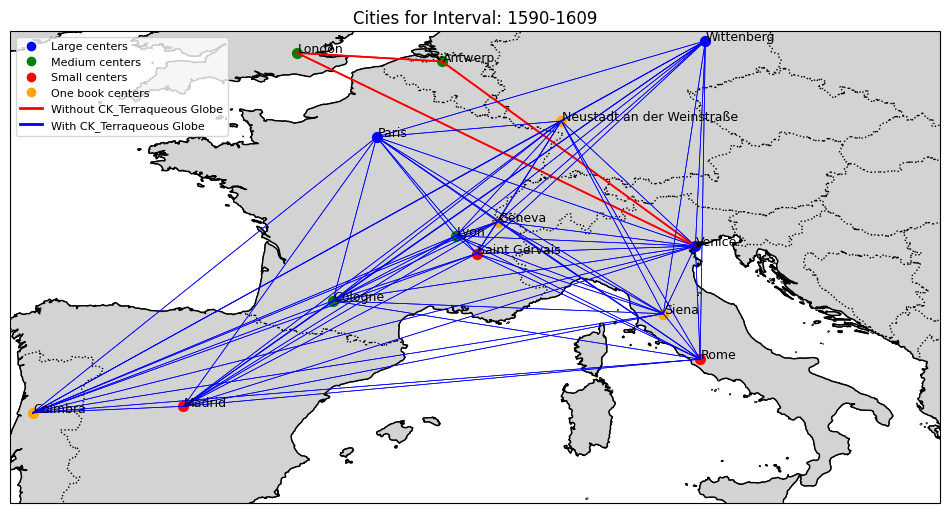

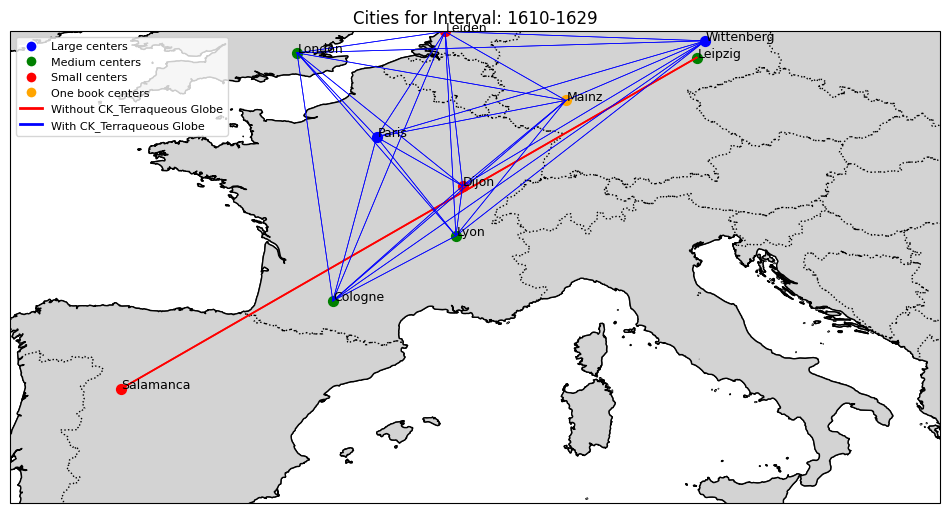

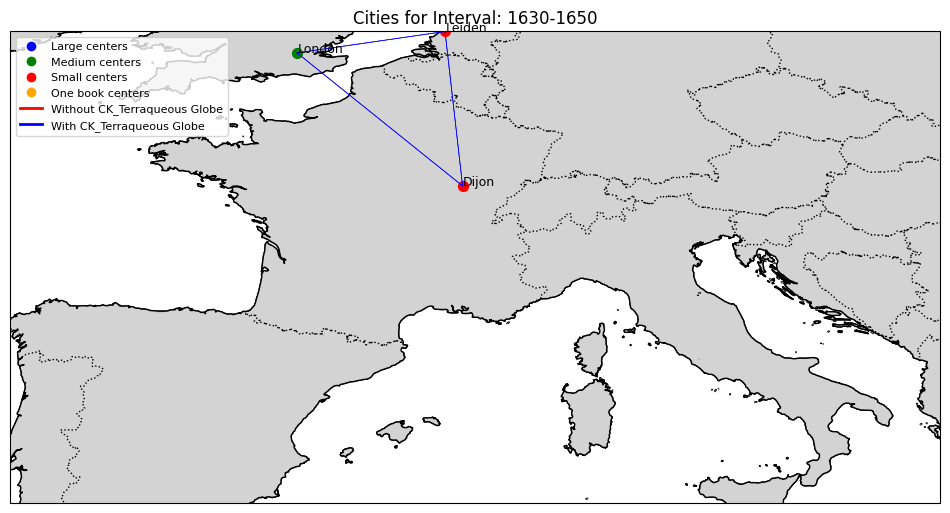

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Ensure the category_to_color dictionary matches only the categories in your dataset
category_to_color = {
    'Large centers': 'blue',
    'Medium centers': 'green',
    'Small centers': 'red',
    'One book centers': 'orange'
}

# Function to plot the map for each interval
def plot_static_map_for_interval(interval):
    # Calculate the bounds for the map dynamically based on the data
    min_lon = filtered_df['longitude'].min()
    max_lon = filtered_df['longitude'].max()
    min_lat = filtered_df['latitude'].min()
    max_lat = filtered_df['latitude'].max()

    # Create a new figure for each interval
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add base map features
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Set map bounds (adjust these values as per your data's extent)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Filter data for the current interval
    df_interval = filtered_df[filtered_df['interval'] == interval]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(df_interval, 
                           geometry=gpd.GeoSeries.from_xy(df_interval['longitude'], df_interval['latitude']),
                           crs="EPSG:4326")

    # Drop duplicate cities based on 'place' column
    gdf_unique_cities = gdf.drop_duplicates(subset=["place"])

    # Lists for storing cities based on conditions
    city_lathe_yes = []  # Lathe machine 'yes'
    city_cks_condition = []  # CK_Additions condition

    # Plot all cities on the map
    for _, row in gdf_unique_cities.iterrows():
        category = row['place_category']
        
        # Ensure that category is valid, otherwise skip
        if category not in category_to_color:
            continue  # Skip invalid categories
        
        color = category_to_color[category]  # Get color for place category

        # Plot the city circle with the assigned color
        ax.scatter(row['longitude'], row['latitude'], color=color, s=50, transform=ccrs.PlateCarree())

        # Add the city name close to the point
        ax.text(row['longitude'] + 0.02, row['latitude'] + 0.02, row['place'], 
                color='black', fontsize=9, ha='left', transform=ccrs.PlateCarree())

        # Check if this city meets the second condition (CK_Additions on Definitions of the Sphere)
        if any(df_interval[df_interval['place'] == row['place']]['terraqueous_globe'].str.strip() == "Without CK_Terraqueous Globe"):
            city_cks_condition.append((row['place'], row['longitude'], row['latitude'], color))  # Store coordinates and city name

        # Check if this city meets the first condition (Lathe Machine = Yes)
        if row['terraqueous_globe'] == 'With CK_Terraqueous Globe':
            city_lathe_yes.append((row['place'], row['longitude'], row['latitude'], color))  # Store coordinates and city name

    # Draw lines between cities meeting the second condition (Red lines)
    for i, (_, lon1, lat1, _) in enumerate(city_cks_condition):
        for j, (_, lon2, lat2, _) in enumerate(city_cks_condition):
            if i != j:  # Avoid lines to the same city
                ax.plot([lon1, lon2], [lat1, lat2], color='red', linewidth=1.2, transform=ccrs.PlateCarree())

    # Draw lines between cities meeting the first condition (Blue lines)
    for i, (_, lon1, lat1, _) in enumerate(city_lathe_yes):
        for j, (_, lon2, lat2, _) in enumerate(city_lathe_yes):
            if i != j:  # Avoid lines to the same city
                ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=0.5, transform=ccrs.PlateCarree())

    # Set title for the current interval
    ax.set_title(f"Cities for Interval: {interval}")

    # Create the legend for place categories (circle colors)
    legend_labels = list(category_to_color.keys())  # Get the place category labels (e.g., "Large Centers", "Medium Cities")
    legend_colors = list(category_to_color.values())  # Get the corresponding colors for the place categories
    
    # Create handles for the circles (place categories)
    place_category_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in legend_colors]
    
    # Create the line color handles (for conditions)
    line_handles = [
        plt.Line2D([0], [0], color='red', lw=2, label="Without CK_Terraqueous Globe"),  # Red lines for CK_Additions
        plt.Line2D([0], [0], color='blue', lw=2, label="With CK_Terraqueous Globe")  # Blue lines for Lathe Machine
    ]
    
    # Combine both the circle handles and line handles into one list
    combined_handles = place_category_handles + line_handles
    combined_labels = legend_labels + ["Without CK_Terraqueous Globe", "With CK_Terraqueous Globe"]
    
    # Add the combined legend to the plot
    ax.legend(handles=combined_handles, labels=combined_labels, loc="upper left", fontsize=8)
  
    # Show the plot
    plt.show()

# Sort the intervals in chronological order
sorted_intervals = sorted(filtered_df['interval'].unique())

# Plot static maps for each time interval
for interval in sorted_intervals:
    plot_static_map_for_interval(interval)


In [29]:
import pandas as pd

# Define the conditions for the "num_spheres" column
def assign_num_spheres(image):
    # Get all the 'cks' values for the current image
    cks_values = filtered_df[filtered_df['images'] == image]['cks'].unique()

    # Check the conditions and return the appropriate value
    if 'CK_08 Spheres' in cks_values or 'CK_07 Spheres' in cks_values:
        return 'less than 9'
    elif 'CK_09 Spheres' in cks_values:
        return '9'
    elif 'CK_10 Spheres' in cks_values:
        return '10'
    elif 'CK_11 Spheres' in cks_values or 'CK_12 Spheres' in cks_values:
        return 'more than 10'
    else:
        # If no conditions match, return None (for debugging purposes)
        return None

# Apply the function to the DataFrame and assign values to the 'num_spheres' column
filtered_df['num_spheres'] = filtered_df['images'].apply(assign_num_spheres)

# Check for any rows where 'num_spheres' is None (which means no condition was matched)
no_condition_matched = filtered_df[filtered_df['num_spheres'].isnull()]

# Print any images that do not fit any of the conditions
if not no_condition_matched.empty:
    print("Images that don't fit any of the conditions:")
    print(no_condition_matched[['image', 'cks', 'num_spheres']])
else:
    print("All images fit one of the conditions.")


All images fit one of the conditions.


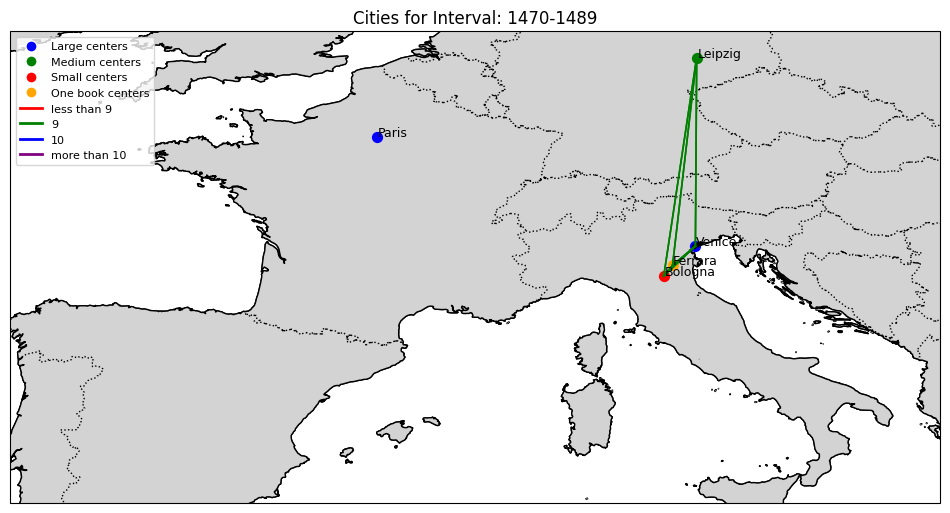

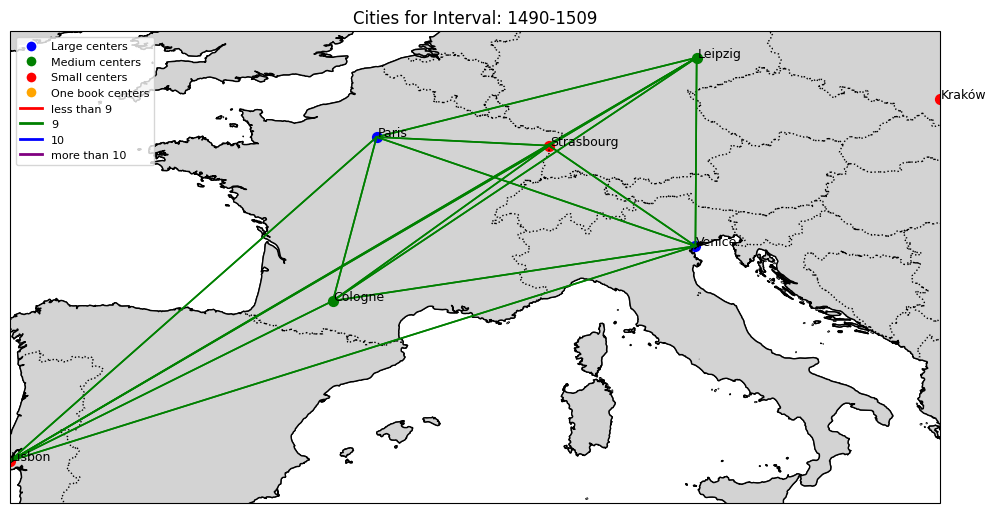

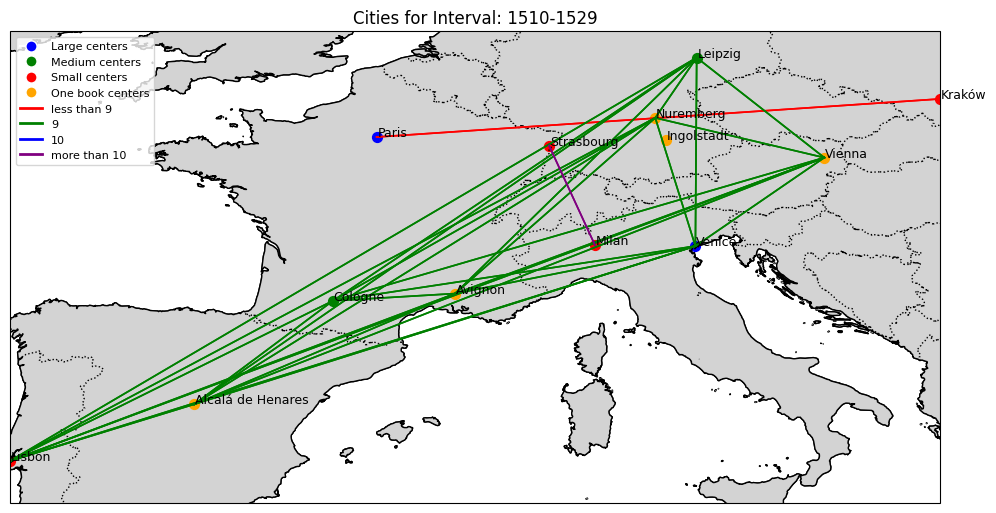

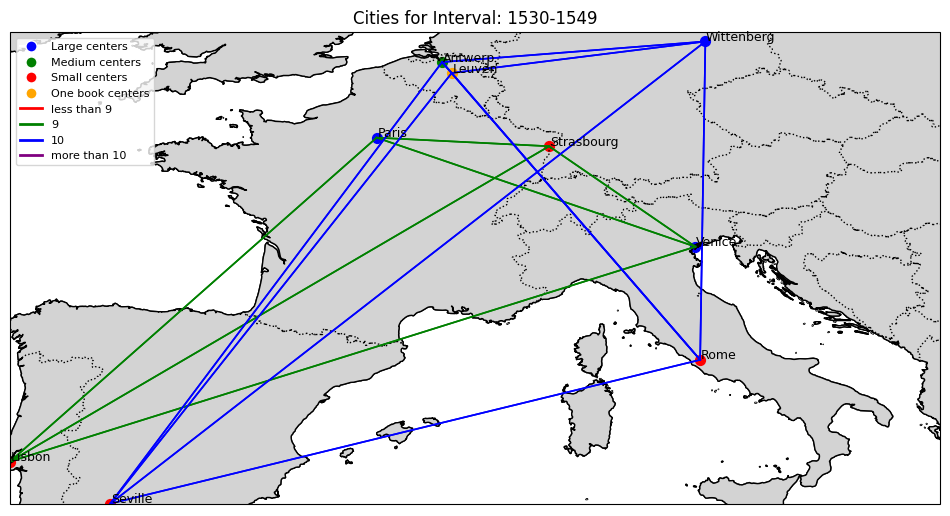

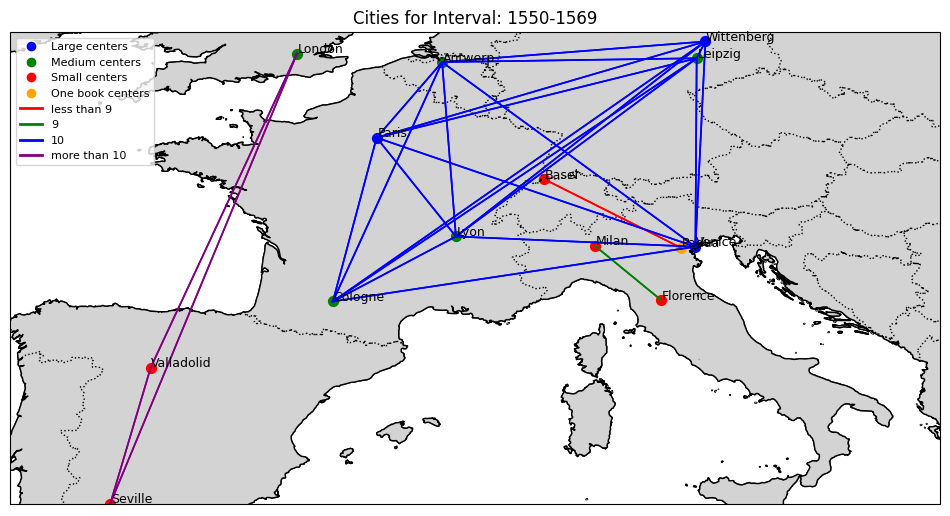

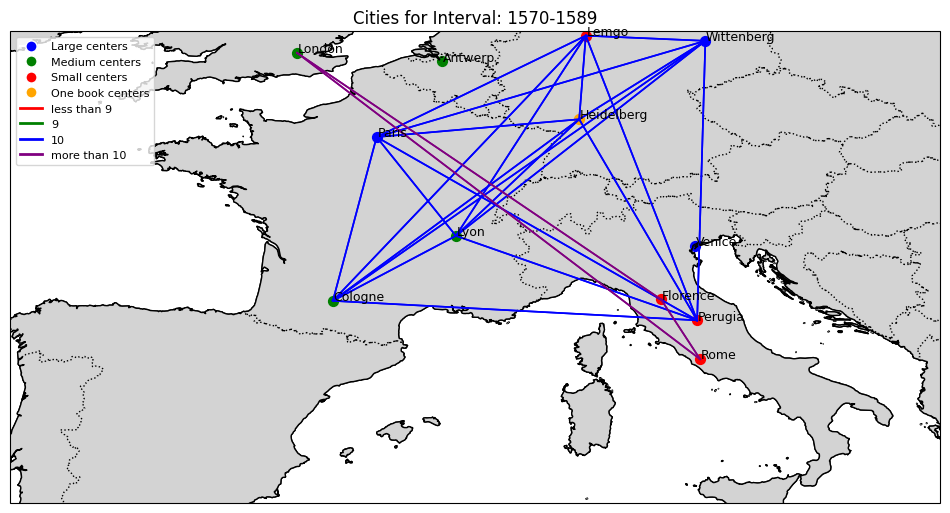

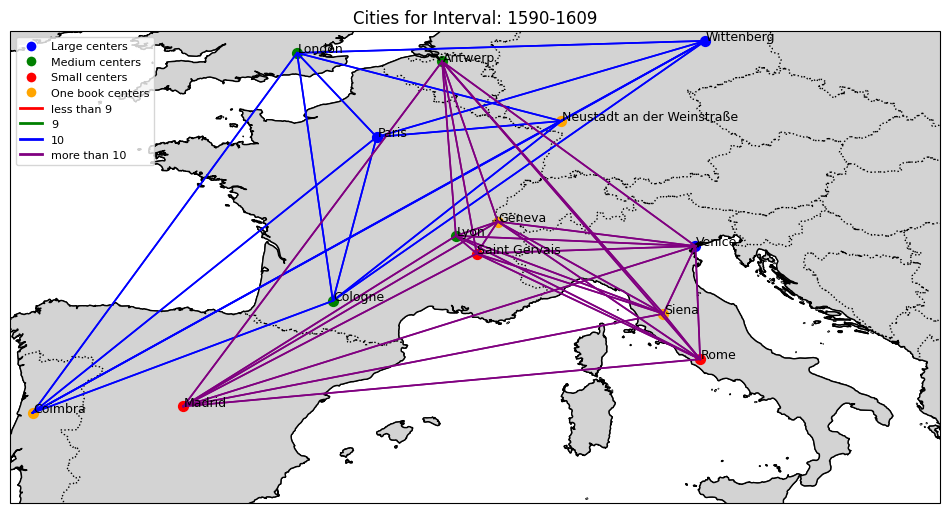

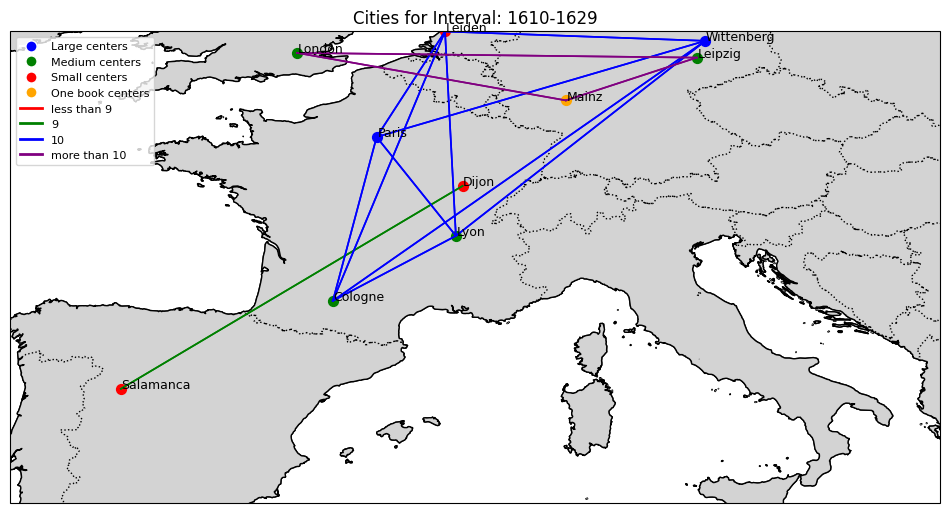

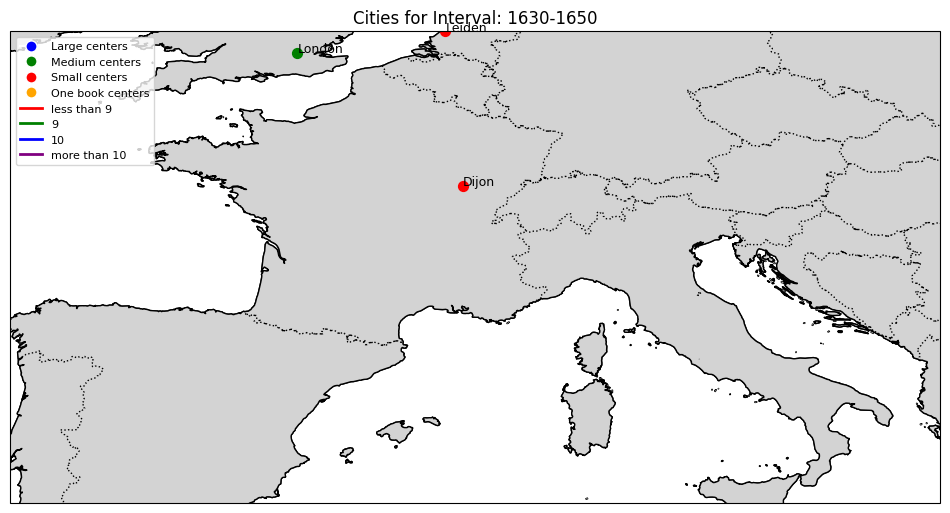

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Ensure the category_to_color dictionary matches only the categories in your dataset
category_to_color = {
    'Large centers': 'blue',
    'Medium centers': 'green',
    'Small centers': 'red',
    'One book centers': 'orange'
}

# Function to plot the map for each interval
def plot_static_map_for_interval(interval):
    # Calculate the bounds for the map dynamically based on the data
    min_lon = filtered_df['longitude'].min()
    max_lon = filtered_df['longitude'].max()
    min_lat = filtered_df['latitude'].min()
    max_lat = filtered_df['latitude'].max()

    # Create a new figure for each interval
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add base map features
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Set map bounds (adjust these values as per your data's extent)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Filter data for the current interval
    df_interval = filtered_df[filtered_df['interval'] == interval]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(df_interval, 
                           geometry=gpd.GeoSeries.from_xy(df_interval['longitude'], df_interval['latitude']),
                           crs="EPSG:4326")

    # Drop duplicate cities based on 'place' column
    gdf_unique_cities = gdf.drop_duplicates(subset=["place"])

    # Lists for storing cities based on num_spheres categories
    city_less_than_9 = []
    city_9 = []
    city_10 = []
    city_more_than_10 = []

    # Plot all cities on the map and categorize them by num_spheres
    for _, row in gdf_unique_cities.iterrows():
        category = row['place_category']
        
        # Ensure that category is valid, otherwise skip
        if category not in category_to_color:
            continue  # Skip invalid categories
        
        color = category_to_color[category]  # Get color for place category

        # Plot the city circle with the assigned color
        ax.scatter(row['longitude'], row['latitude'], color=color, s=50, transform=ccrs.PlateCarree())

        # Add the city name close to the point
        ax.text(row['longitude'] + 0.02, row['latitude'] + 0.02, row['place'], 
                color='black', fontsize=9, ha='left', transform=ccrs.PlateCarree())

        # Categorize cities based on num_spheres
        num_spheres_value = row['num_spheres']
        
        if num_spheres_value == 'less than 9':
            city_less_than_9.append((row['place'], row['longitude'], row['latitude'], color))
        elif num_spheres_value == '9':
            city_9.append((row['place'], row['longitude'], row['latitude'], color))
        elif num_spheres_value == '10':
            city_10.append((row['place'], row['longitude'], row['latitude'], color))
        elif num_spheres_value == 'more than 10':
            city_more_than_10.append((row['place'], row['longitude'], row['latitude'], color))

    # Function to draw lines between cities within the same category
    def draw_lines_between_cities(city_list, line_color):
        for i, (_, lon1, lat1, _) in enumerate(city_list):
            for j, (_, lon2, lat2, _) in enumerate(city_list):
                if i != j:  # Avoid lines to the same city
                    ax.plot([lon1, lon2], [lat1, lat2], color=line_color, linewidth=1.2, transform=ccrs.PlateCarree())

    # Draw lines between cities in each num_spheres category
    draw_lines_between_cities(city_less_than_9, 'red')
    draw_lines_between_cities(city_9, 'green')
    draw_lines_between_cities(city_10, 'blue')
    draw_lines_between_cities(city_more_than_10, 'purple')

    # Set title for the current interval
    ax.set_title(f"Cities for Interval: {interval}")

    # Create the legend for place categories (circle colors)
    legend_labels = list(category_to_color.keys())  # Get the place category labels (e.g., "Large Centers", "Medium Cities")
    legend_colors = list(category_to_color.values())  # Get the corresponding colors for the place categories
    
    # Create handles for the circles (place categories)
    place_category_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in legend_colors]
    
    # Create the line color handles (for num_spheres categories)
    line_handles = [
        plt.Line2D([0], [0], color='red', lw=2, label="less than 9"),  # Red lines for less than 9
        plt.Line2D([0], [0], color='green', lw=2, label="9"),  # Green lines for 9
        plt.Line2D([0], [0], color='blue', lw=2, label="10"),  # Blue lines for 10
        plt.Line2D([0], [0], color='purple', lw=2, label="more than 10")  # Purple lines for more than 10
    ]
    
    # Combine both the circle handles and line handles into one list
    combined_handles = place_category_handles + line_handles
    combined_labels = legend_labels + ["less than 9", "9", "10", "more than 10"]
    
    # Add the combined legend to the plot
    ax.legend(handles=combined_handles, labels=combined_labels, loc="upper left", fontsize=8)
  
    # Show the plot
    plt.show()

# Sort the intervals in chronological order
sorted_intervals = sorted(filtered_df['interval'].unique())

# Plot static maps for each time interval
for interval in sorted_intervals:
    plot_static_map_for_interval(interval)


In [32]:
# #same code for saving output as files

# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import geopandas as gpd
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Ensure the category_to_color dictionary matches only the categories in your dataset
# category_to_color = {
#     'Large centers': 'blue',
#     'Medium centers': 'green',
#     'Small centers': 'red',
#     'One book centers': 'orange'
# }

# # Directory to save the images
# output_dir = "saved_maps"
# os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

# # Function to plot the map for each interval
# def plot_static_map_for_interval(interval):
#     # Calculate the bounds for the map dynamically based on the data
#     min_lon = filtered_df['longitude'].min()
#     max_lon = filtered_df['longitude'].max()
#     min_lat = filtered_df['latitude'].min()
#     max_lat = filtered_df['latitude'].max()

#     # Create a new figure for each interval
#     fig, ax = plt.subplots(figsize=(12, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    
#     # Add base map features
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.LAND, edgecolor='black')
#     ax.add_feature(cfeature.LAND, facecolor='lightgray')

#     # Set map bounds (adjust these values as per your data's extent)
#     ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

#     # Filter data for the current interval
#     df_interval = filtered_df[filtered_df['interval'] == interval]

#     # Create a GeoDataFrame
#     gdf = gpd.GeoDataFrame(df_interval, 
#                            geometry=gpd.GeoSeries.from_xy(df_interval['longitude'], df_interval['latitude']),
#                            crs="EPSG:4326")

#     # Drop duplicate cities based on 'place' column
#     gdf_unique_cities = gdf.drop_duplicates(subset=["place"])

#     # Lists for storing cities based on num_spheres categories
#     city_less_than_9 = []
#     city_9 = []
#     city_10 = []
#     city_more_than_10 = []

#     # Plot all cities on the map and categorize them by num_spheres
#     for _, row in gdf_unique_cities.iterrows():
#         category = row['place_category']
        
#         # Ensure that category is valid, otherwise skip
#         if category not in category_to_color:
#             continue  # Skip invalid categories
        
#         color = category_to_color[category]  # Get color for place category

#         # Plot the city circle with the assigned color
#         ax.scatter(row['longitude'], row['latitude'], color=color, s=50, transform=ccrs.PlateCarree())

#         # Add the city name close to the point
#         ax.text(row['longitude'] + 0.02, row['latitude'] + 0.02, row['place'], 
#                 color='black', fontsize=9, ha='left', transform=ccrs.PlateCarree())

#         # Categorize cities based on num_spheres
#         num_spheres_value = row['num_spheres']
        
#         if num_spheres_value == 'less than 9':
#             city_less_than_9.append((row['place'], row['longitude'], row['latitude'], color))
#         elif num_spheres_value == '9':
#             city_9.append((row['place'], row['longitude'], row['latitude'], color))
#         elif num_spheres_value == '10':
#             city_10.append((row['place'], row['longitude'], row['latitude'], color))
#         elif num_spheres_value == 'more than 10':
#             city_more_than_10.append((row['place'], row['longitude'], row['latitude'], color))

#     # Function to draw lines between cities within the same category
#     def draw_lines_between_cities(city_list, line_color):
#         for i, (_, lon1, lat1, _) in enumerate(city_list):
#             for j, (_, lon2, lat2, _) in enumerate(city_list):
#                 if i != j:  # Avoid lines to the same city
#                     ax.plot([lon1, lon2], [lat1, lat2], color=line_color, linewidth=1.2, transform=ccrs.PlateCarree())

#     # Draw lines between cities in each num_spheres category
#     draw_lines_between_cities(city_less_than_9, 'red')
#     draw_lines_between_cities(city_9, 'green')
#     draw_lines_between_cities(city_10, 'blue')
#     draw_lines_between_cities(city_more_than_10, 'purple')

#     # Set title for the current interval
#     ax.set_title(f"Cities for Interval: {interval}")

#     # Create the legend for place categories (circle colors)
#     legend_labels = list(category_to_color.keys())  # Get the place category labels (e.g., "Large Centers", "Medium Cities")
#     legend_colors = list(category_to_color.values())  # Get the corresponding colors for the place categories
    
#     # Create handles for the circles (place categories)
#     place_category_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in legend_colors]
    
#     # Create the line color handles (for num_spheres categories)
#     line_handles = [
#         plt.Line2D([0], [0], color='red', lw=2, label="less than 9"),  # Red lines for less than 9
#         plt.Line2D([0], [0], color='green', lw=2, label="9"),  # Green lines for 9
#         plt.Line2D([0], [0], color='blue', lw=2, label="10"),  # Blue lines for 10
#         plt.Line2D([0], [0], color='purple', lw=2, label="more than 10")  # Purple lines for more than 10
#     ]
    
#     # Combine both the circle handles and line handles into one list
#     combined_handles = place_category_handles + line_handles
#     combined_labels = legend_labels + ["less than 9", "9", "10", "more than 10"]
    
#     # Add the combined legend to the plot
#     ax.legend(handles=combined_handles, labels=combined_labels, loc="upper left", fontsize=8)
  
#     # Save the plot as a PNG file
#     output_filepath = os.path.join(output_dir, f"interval_{interval}.png")
#     plt.savefig(output_filepath, bbox_inches='tight', dpi=300)  # Save with high resolution
#     plt.close(fig)  # Close the figure to avoid memory overload when saving multiple images

# # Sort the intervals in chronological order
# sorted_intervals = sorted(filtered_df['interval'].unique())

# # Plot static maps for each time interval and save as files
# for interval in sorted_intervals:
#     plot_static_map_for_interval(interval)

# print(f"Maps have been saved in the '{output_dir}' directory.")


Maps have been saved in the 'saved_maps' directory.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Ensure the category_to_color dictionary matches only the categories in your dataset
category_to_color = {
    'Large centers': 'blue',
    'Medium centers': 'green',
    'Small centers': 'red',
    'One book centers': 'orange'
}

# Function to plot the map for each interval
def plot_static_map_for_interval(interval, output_folder="output_maps"):
    print(f"Plotting for interval: {interval}")
    
    # Calculate the bounds for the map dynamically based on the data
    min_lon = filtered_df['longitude'].min()
    max_lon = filtered_df['longitude'].max()
    min_lat = filtered_df['latitude'].min()
    max_lat = filtered_df['latitude'].max()

    # Create a new figure for each interval
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add base map features
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Set map bounds (adjust these values as per your data's extent)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Filter data for the current interval
    df_interval = filtered_df[filtered_df['interval'] == interval]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(df_interval, 
                           geometry=gpd.GeoSeries.from_xy(df_interval['longitude'], df_interval['latitude']),
                           crs="EPSG:4326")

    # Drop duplicate cities based on 'place' column
    gdf_unique_cities = gdf.drop_duplicates(subset=["place"])

    # Lists for storing cities based on conditions
    city_lathe_yes = []  # Lathe machine 'yes'
    city_cks_condition = []  # CK_Additions condition

    # Plot all cities on the map
    for _, row in gdf_unique_cities.iterrows():
        category = row['place_category']
        
        # Ensure that category is valid, otherwise skip
        if category not in category_to_color:
            continue  # Skip invalid categories
        
        color = category_to_color[category]  # Get color for place category

        # Plot the city circle with the assigned color
        ax.scatter(row['longitude'], row['latitude'], color=color, s=50, transform=ccrs.PlateCarree())

        # Add the city name close to the point
        ax.text(row['longitude'] + 0.02, row['latitude'] + 0.02, row['place'], 
                color='black', fontsize=9, ha='left', transform=ccrs.PlateCarree())

        # Check if this city meets the second condition (CK_Additions on Definitions of the Sphere)
        if any(df_interval[df_interval['place'] == row['place']]['terraqueous_globe'].str.strip() == "Without CK_Terraqueous Globe"):
            city_cks_condition.append((row['place'], row['longitude'], row['latitude'], color))  # Store coordinates and city name

        # Check if this city meets the first condition (Lathe Machine = Yes)
        if row['terraqueous_globe'] == 'With CK_Terraqueous Globe':
            city_lathe_yes.append((row['place'], row['longitude'], row['latitude'], color))  # Store coordinates and city name

    # Draw lines between cities meeting the second condition (Red lines)
    for i, (_, lon1, lat1, _) in enumerate(city_cks_condition):
        for j, (_, lon2, lat2, _) in enumerate(city_cks_condition):
            if i != j:  # Avoid lines to the same city
                ax.plot([lon1, lon2], [lat1, lat2], color='red', linewidth=1.2, transform=ccrs.PlateCarree())

    # Draw lines between cities meeting the first condition (Blue lines)
    for i, (_, lon1, lat1, _) in enumerate(city_lathe_yes):
        for j, (_, lon2, lat2, _) in enumerate(city_lathe_yes):
            if i != j:  # Avoid lines to the same city
                ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=0.5, transform=ccrs.PlateCarree())

    # Set title for the current interval
    ax.set_title(f"Cities for Interval: {interval}")

    # Create the legend for place categories (circle colors)
    legend_labels = list(category_to_color.keys())  # Get the place category labels (e.g., "Large Centers", "Medium Cities")
    legend_colors = list(category_to_color.values())  # Get the corresponding colors for the place categories
    
    # Create handles for the circles (place categories)
    place_category_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) for color in legend_colors]
    
    # Create the line color handles (for conditions)
    line_handles = [
        plt.Line2D([0], [0], color='red', lw=2, label="Without CK_Terraqueous Globe"),  # Red lines for CK_Additions
        plt.Line2D([0], [0], color='blue', lw=2, label="With CK_Terraqueous Globe")  # Blue lines for Lathe Machine
    ]
    
    # Combine both the circle handles and line handles into one list
    combined_handles = place_category_handles + line_handles
    combined_labels = legend_labels + ["Without CK_Terraqueous Globe", "With CK_Terraqueous Globe"]
    
    # Add the combined legend to the plot
    ax.legend(handles=combined_handles, labels=combined_labels, loc="upper left", fontsize=8)

    # Save the plot as an image
    output_file = f"{output_folder}/interval_{interval}_map.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved map for interval {interval} to {output_file}")
  
    # Close the figure to release memory
    plt.close(fig)

# Sort the intervals in chronological order
sorted_intervals = sorted(filtered_df['interval'].unique())

# Create an output folder if it doesn't exist
import os
output_folder = "output_maps"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Plot static maps for each time interval and save them as files
for interval in sorted_intervals:
    plot_static_map_for_interval(interval, output_folder)


Plotting for interval: 1470-1489
Saved map for interval 1470-1489 to output_maps/interval_1470-1489_map.png
Plotting for interval: 1490-1509
Saved map for interval 1490-1509 to output_maps/interval_1490-1509_map.png
Plotting for interval: 1510-1529
Saved map for interval 1510-1529 to output_maps/interval_1510-1529_map.png
Plotting for interval: 1530-1549
Saved map for interval 1530-1549 to output_maps/interval_1530-1549_map.png
Plotting for interval: 1550-1569
Saved map for interval 1550-1569 to output_maps/interval_1550-1569_map.png
Plotting for interval: 1570-1589
Saved map for interval 1570-1589 to output_maps/interval_1570-1589_map.png
Plotting for interval: 1590-1609
Saved map for interval 1590-1609 to output_maps/interval_1590-1609_map.png
Plotting for interval: 1610-1629
Saved map for interval 1610-1629 to output_maps/interval_1610-1629_map.png
Plotting for interval: 1630-1650
Saved map for interval 1630-1650 to output_maps/interval_1630-1650_map.png
